# Project

In [212]:
import os
import sys
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

def read_ltspice_ac(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        z = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            complex = p[1].split(",")
            y.append(float(complex[0]))
            z.append(float(complex[1]))

    return x, y, z

def read_ltspice_xy(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))
        
    return x, y

def closest(lst, K):      
    lst = np.asarray(lst)
    index = (np.abs(lst - K)).argmin()
    return index

def plot_xlogy(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogx(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
def plot_xy(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
def plot_loglog(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10.0, 7.5))
    ax.loglog(x, y, 'b')
    ax.grid();
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
k = 1.38e-23                 # Boltzmann constant, J/K
T = 300                      # room temperature (27C) in Kelvin
q = 1.6e-19                  # charge of an electron
kT = k*T


In [213]:
def analyze(C_D, C_f, R_f, e_namp, i_namp, f_T, C_filter, R_filter, R_1, R_2):
    f = np.linspace(1, 10**9, 10**5)
    s = np.multiply(2*np.pi, f)

    zeta = 1 / np.sqrt(2)
    omega_u = 2 * np.pi * f_T
    omega_0_2 = omega_u / (R_f*C_D)
    omega_0 = np.sqrt(omega_0_2)

    tf_tia_mag = R_f * omega_0_2 / np.sqrt( (s*np.sqrt(2)*omega_0)**2 + (omega_0_2-s**2)**2)
    tf_filter_mag = 1 / np.sqrt((s*R_filter*C_filter)**2 + 1)
    tf_noninv_mag = 1 + R_2 / R_1 # assuming ideal opamp
    tf_amp_mag = tf_tia_mag * tf_filter_mag * tf_noninv_mag
    
    #plot_xlogy(f, tf_amp_mag * 2e-6, "frequency", "V/uA")
    tf_amp_db = 20 * np.log10(tf_amp_mag)
    plot_xlogy(f, tf_amp_db, "frequency", "dB", "calculated gain")
    mhz_idx = closest(f, 1e6)
    display(f'dB at 1MHz: {tf_amp_db[mhz_idx]}')
    
    i_tia_e_na = e_namp * s * C_D
    e_tia_na = i_tia_e_na * tf_tia_mag

    e_nRf2 = 4 * kT * R_f
    e_nRf = np.sqrt(e_nRf2)
    e_tia_nRf = (e_nRf/R_f) * tf_tia_mag

    e_tia = np.sqrt(e_tia_na**2 + e_tia_nRf**2)
    
    #plot_xlogy(f, e_tia, "frequency", "e_tia")
    x = np.argmax(e_tia)
    display(f'TIA noise peak at: {f[x]} mag: {e_tia[x]}')
    
    e_nRfilter = np.sqrt(4 * kT * R_filter) * tf_noninv_mag
    e_nR2 = np.sqrt(4 * kT * R_2)
    e_nR1 = np.sqrt(4 * kT * R_1) * tf_noninv_mag

    R_1_p_R_2 = R_1 * R_2 / (R_1 + R_2)
    e_i_namp = i_namp * R_1_p_R_2 * tf_noninv_mag
    e_e_namp = e_namp * tf_noninv_mag

    e_tot = np.sqrt((e_tia * tf_filter_mag * tf_noninv_mag) ** 2 + e_nRfilter**2 + e_nR2**2 + e_nR1**2 + e_i_namp**2 + e_e_namp**2)
    
    plot_xlogy(f, e_tot, "frequency", "e_tot", "calculated noise")
    x = np.argmax(e_tot)
    f[x],e_tot[x]
    
    e_tot_int = np.trapz(e_tot)
    i_tot_int_input = e_tot_int / 1e6
    i_ns_tot =  0.8e-12 * np.sqrt(1e6)
    
    
    NFac = np.sqrt(1 + (i_tot_int_input**2) / (i_ns_tot**2))
    NF = 10*np.log10(NFac)
    
    display(f'Structure noise peak at: {f[x]} mag: {e_tot[x]}')
    display(f'integrated input noise: {i_tot_int_input} Amp NF: {NFac} dB ratio {NF}')
    

In [214]:
def plot_ltspice_ac(fname):
    fsim, rsim, jsim = read_ltspice_ac(fname)
    magsim = np.sqrt(np.asarray(rsim)**2 + np.asarray(jsim)**2)

    dbsim = 20*np.log10(np.divide(magsim, 2e-6))

    mhz100 = closest(fsim, 100 * 1e6)
    
    plot_xlogy(fsim, magsim, "frequency (Hz)", "voltage (V)", "simulated output voltage at 2e-12A input")
    plot_xlogy(fsim, dbsim, "frequency (Hz)", "gain (dB)", "simulated gain")
    # plot_xlogy(fsim, np.arctan2(jsim, rsim) * 180/np.pi, "frequency (Hz)", "simulated Vphase (rad)", "simulated phase")

    mhz_idx = closest(fsim, 1e6)
    khz_idx = closest(fsim, 1e3)
    display(f'gain at {fsim[khz_idx]} Hz: {dbsim[khz_idx]} dB')
    display(f'gain at {fsim[mhz_idx]} Hz: {dbsim[mhz_idx]} dB')

__Design Specifications__

A photodiode transimpedance amplifier (TIA) is to implemented subject to the following specifications:

| Parameter                            | Specification   | Conditions | Unit |
| :----------------                    | :------:        |:--------------|:--------------------: |
| Transimpedance gain (full signal path)                        | $1$         |               | $V/\mu A$ |
| Transimpedance bandwidth ($f_{3dB}$)            | $1$             |               | $MHz$ |
| Minimum photodiode current ($i_d$)                  | $2$         |               | $\mu A$ | 
| Photodiode capacitance ($C_d$)              | $150$      |               | $pF$ |
| Closed-loop gain magnitude peaking          | $0$      |               |$dB$|
| $rms$ noise figure ($F = 1 + i_n^2/i_{ns}^2$)        | $\leq 0.5$           |               | $dB$ |
| Power dissipation ($I_{DD} \cdot (V_{CC} + V_{EE}) $) | Optimize   |               |$mW$ |
| Cost-per-unit (1000 units)          | Optimize       |               |$\$$ |

## Analysis

Transimpedance gain: $ G = 1 / 1e^{-6} = 1M\Omega$

Diode has only shot noise: $e_{nd} = \sqrt{2 q I_d}$

\begin{equation}
NF = \sqrt{1+\frac{i^2_{n}}{i^2_{ns}}} \\
i_{ns} = 0.8pA\\
NF = 0.5dB\\
.5 dB = 10 \times 10^{\frac{0.5}{10}} = 1.12202\\
1.12202^2 \approx 1.126 \\
1.126 = 1 + \frac{i^2_{n}}{0.64}\\
0.64(1.126 - 1)= i^2_{n}
\end{equation}

In [215]:
i_ns = np.sqrt(2 * q * 2e-6) # 2uA min current through diode
display(f'i_ns: {i_ns}')

i_n_spec = np.sqrt(0.64 * (1.12202**2 - 1))
i_n_tot_spec = i_n_spec * np.sqrt(1e6)

display(f'i_n_spec: {i_n_spec}pA/rtHz i_n_tot_spec: {i_n_tot_spec}pA')

'i_ns: 7.999999999999999e-13'

'i_n_spec: 0.4070804385572955pA/rtHz i_n_tot_spec: 407.08043855729545pA'

The following main sources were reviewed for theory and design of TIAs:
- Graeme Book 1995 - discrete bootstrap frontend
- Hobbs Paper 2001 - discrete cascode + bootstrap "no such IC exists"
- Hobbs Book 2009 - same as paper "expensive IC exists"
- Hamamtsu Opto-semiconductor Handbook 2014 - ~dozen IC only circuits, 1 JFET circuit (low cost)

Overall, for moderate bandwidths (1MHz) and large photo diode capacitance (150pf) the literature shows a trend towards simpler designs with either few or no components in the frontend. The following ICs were evaluated for suitability in a design without a discrete frontend:

| Parameter | LF356 | LTC6269 |  ADA4891 | Unit |
| :----------------:  | :----------------: | :----------------: | :----------------: | :---: |
| $i_n$ | f=1kHz, V_C=15V, 10 | f=100kHz, V_C=2.75V, 5.5 | ? | fA |
| $e_n$ | f=1kHz, V_C=15V, 12 | f=1MHz, V_C=2.75V, 4.3 | f=1MHz, V_C=3V, 9 | nV/rtHz |
| $f_T$ | 5 | 500 | V_C=3.3V 190 | MHz |
| $C_{in}$| 3 | .45 | 3.2 | pF|
| Current Supply | 75 | 51 | 14 | mW |
| price / 1000 | 1 Channel, .9 | 2 Channel, 7 | 2 Channel, 1.7 | $ |

The Texas Instruments LF356 is proposed by Hobbs 2001. The proposed design relies on a discrete frontend implementing a bootstrap and a cascode component with a single opamp. The Analog LTC6269 was evaluated in the proof of concept stage of the project and a single IC solution was proposed in the presentation of the project. Lastly, a cheaper alternative, the ADA4891 is presented.

## Transfer Function

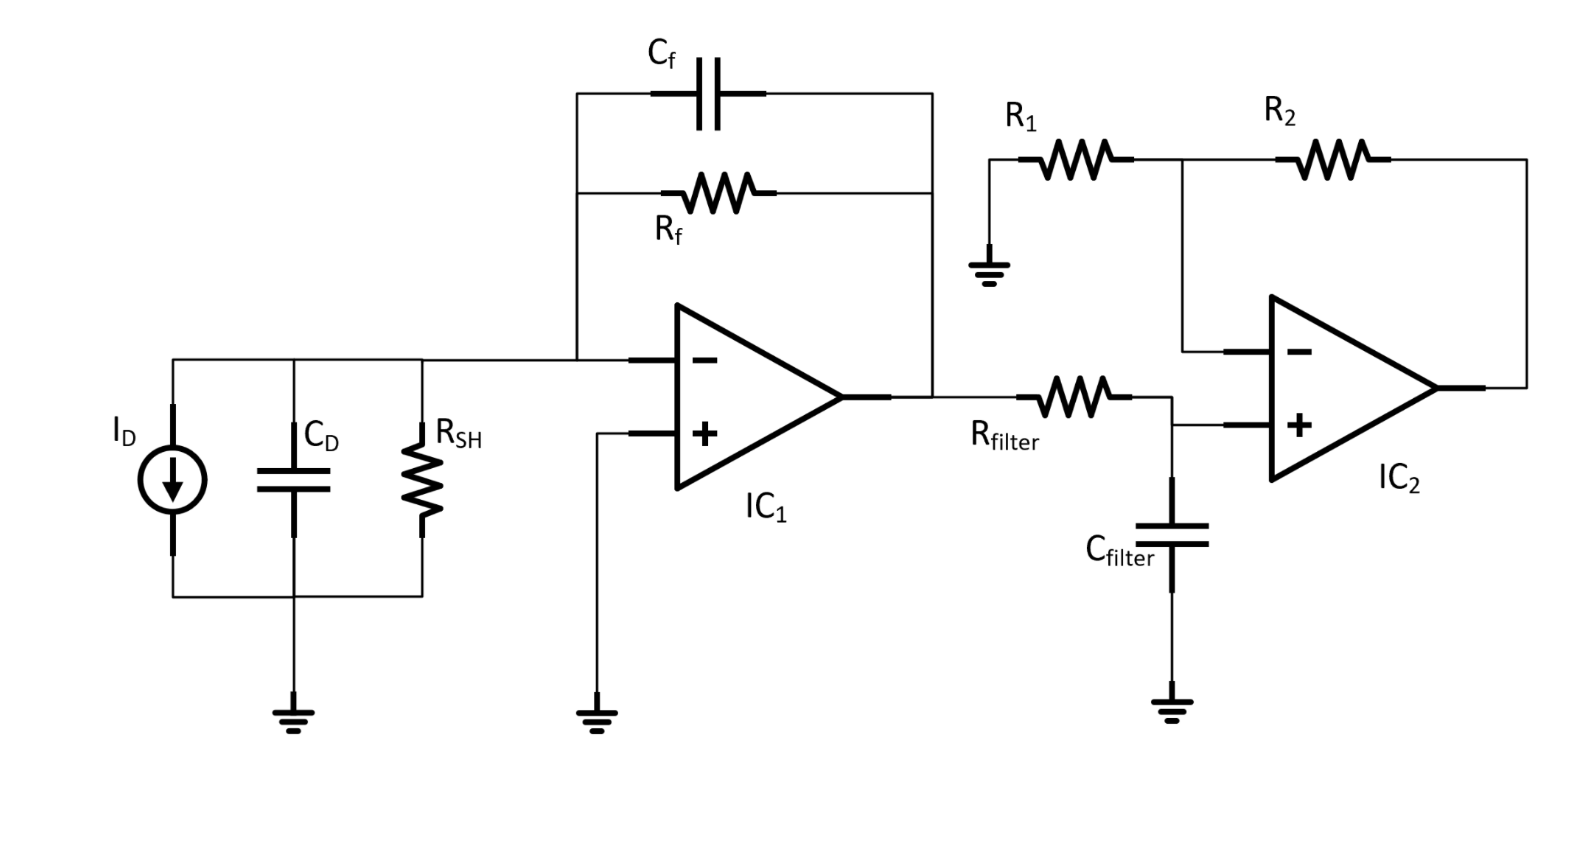

The proposed solution makes use of modern JFET operational amplifiers to implement a naive two stage TIA structure. The structure consists of 3 stages:
1. TIA
2. passive filter
3. non-inverting opamp amplifier

The first stage is modelled accurately although the input capacitance of the opamp is assummed to be $C_D >> C_{amp} \approx 0$.

The passive filter is modelled without parastics and the gain stage is modelled as an ideal opamp. 

The two proposed solutions rely on 2 channel opamp ICs with a relatively high GBP. It is reasonable to simplify the gain stage as an ideal opamp because the majority of the gain (or more precisely transconductance) is achieved in the TIA stage. The gain stage has the same high GBP since both stages are realized with a single IC. Thanks to this choice, the gain stage is very far from hitting GBP limitations.

TIA stage:
\begin{equation}
I_{in} = I_{C_D} + I_{C_f} + I_{R_f}\\
v_- = - \frac{v_{out}}{A_{ol}} \\
I_{C_D} = \frac{v_-}{\frac{1}{sC_D}} = sC_Dv_-\\
I_{C_f} = (v_- - v_{out})s C_f \\
I_{R_f} = (v_- - v_{out})\frac{1}{R_f} \\
I_{in} = v_- s C_D + v_- s C_f - v_{out} s C_f + \frac{v_-}{R_f} - \frac{v_{out}}{R_f} \\
 = v_- \left(sC_D + \frac{1}{R_f} + s C_f\right) - v_{out}\left(\frac{1}{R_f} + s C_f\right)\\
 = - \frac{v_{out}}{A_{ol}} \left( sC_D + \frac{1}{R_f} + s C_f\right) - v_{out}\left( \frac{1}{R_f} + s C_f\right) \\
= -\frac{v_{out}}{A_{ol}}\left( \frac{s C_D R_f + 1 + s C_f R_f}{R_f} \right) - v_{out}\left( \frac{1+s C_f R_f}{R_f} \right) \\
= - \frac{v_{out}}{A_{ol} R_f}\left( 1 + s R_f (C_D + C_f) + A_{ol}(1 + sC_fR_f)\right) \\
-\frac{v_{out}}{I_{in}} = \frac{A_{ol}R_f}{1 + s R_f (C_D + C_f) + A_{ol}(1 + sC_fR_f)}
\end{equation}

\begin{equation}
A_{ol} = \frac{A_0}{1 + \frac{s}{s_p}} = \frac{A_0s_p}{s_p + s} = \frac{\omega_u}{s_p + s}
\end{equation}

for $s >> s_p \approx \frac{\omega_u}{s}$

for $C_D >> C_f, C_D + C_f \approx C_D$

\begin{equation}
-\frac{v_{out}}{I_{in}} = \frac{\omega_u R_f}{1 + s^2R_fC_D + \omega_u + s \omega_u C_f R_f}\\
= R_f \frac{\frac{\omega_u}{R_f C_D}}{s^2 + s \frac{\omega_uC_f}{C_D} + \frac{1+\omega_u}{R_fC_D}}
\end{equation}

The GBP product of the opamp is large: $\omega_u + 1 \approx \omega_u$

$\zeta = \frac{1}{\sqrt{2}}$

$\omega_u = 2 \pi f_T$

\begin{equation}
\omega^2_0= \frac{\omega_u}{R_fC_D}\\
\omega_0 = \sqrt{\frac{\omega_u}{R_fC_D}}
\end{equation}


\begin{equation}
H_1(s) = R_f \frac{\frac{\omega_u}{R_fC_D}}{s^2 + s 2 \zeta \sqrt{\frac{\omega_u}{R_fC_D}} + \frac{\omega_u}{R_fC_D}}\\
|H_1(s)| = R_f \frac{\omega^2_0}{\sqrt{(s\sqrt{2}\omega_0)^2 + (\omega^2_0-s^2)^2}}
\end{equation}

Passive filter:

\begin{equation}
H_2(s) = \frac{1}{1 + sR_{filter}C_{filter}}\\
|H_2(s)| = \frac{1}{\sqrt{(sR_{filter}C_{filter})^2 + 1}}
\end{equation}

Non-inverting amplifier:

\begin{equation}
|H_3(s)| = 1 + \frac{R_2}{R_1}
\end{equation}

Full structure:

\begin{equation}
|H(s)| = |H_1(s)| \times |H_2(s)| \times | H_3(s)|
\end{equation}

## Predicted Gain and Noise

Using the transfer function derived in the previous section, the structure is populated with 2 different opamps: LTC6269 and ADA4891. For each the predicted gain and noise are plotted.

In [216]:
C_D = 150e-12 # pF

# LTC6269
e_namp_ltc = 4.3e-9 # nV
i_namp_ltc = 5.3e-15 # fA
f_T_ltc = 500e6 # MHz

# ADA4891
e_namp_ada = 9e-9 # nV
i_namp_ada = 15e-15 # fA conservative estimate since no info in data sheet
f_T_ada = 190e6 # MHz value at 3V V_CC


'dB at 1MHz: 116.90394201445763'

'TIA noise peak at: 1490015.8986589867 mag: 1.023500588715659e-06'

'Structure noise peak at: 1110012.09900099 mag: 2.8721629416555657e-06'

'integrated input noise: 3.89686250733672e-09 Amp NF: 4.972665501438625 dB ratio 6.965892463294898'

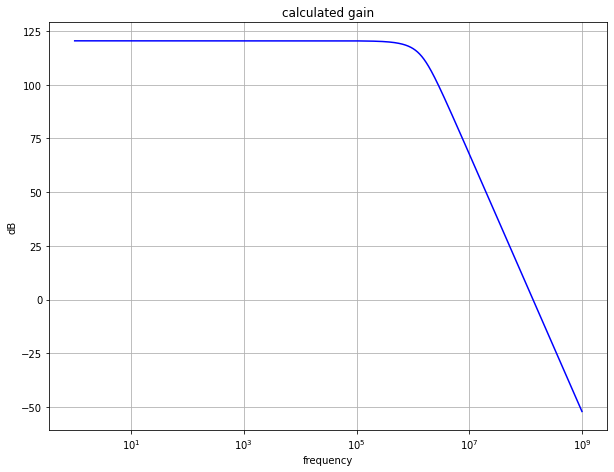

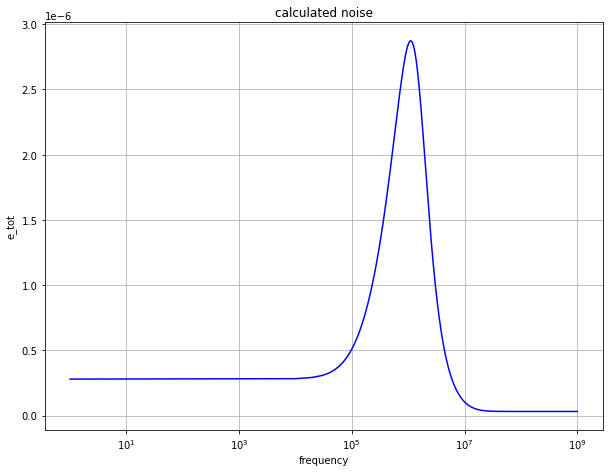

In [217]:
analyze(C_D, 0.68e-12, 240e3, e_namp_ltc, i_namp_ltc, f_T_ltc, 1.5e-9, 100, 1.5e3, 5.1e3)

'dB at 1MHz: 117.18014939002174'

'TIA noise peak at: 1240013.3988839888 mag: 9.715241821917786e-07'

'Structure noise peak at: 1060011.5990459905 mag: 6.160484119376752e-06'

'integrated input noise: 9.434508515728325e-09 Amp NF: 11.835457250708982 dB ratio 10.731850411095216'

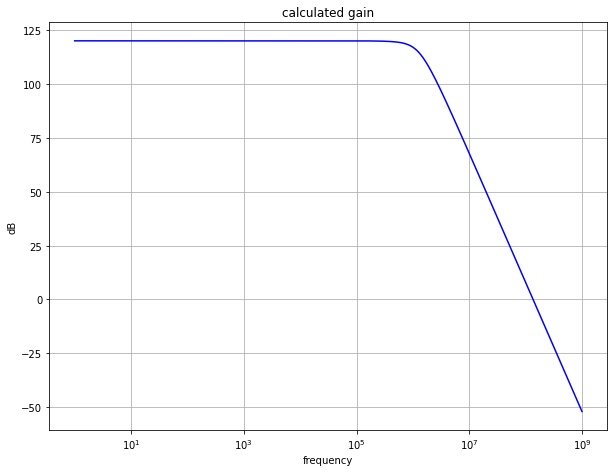

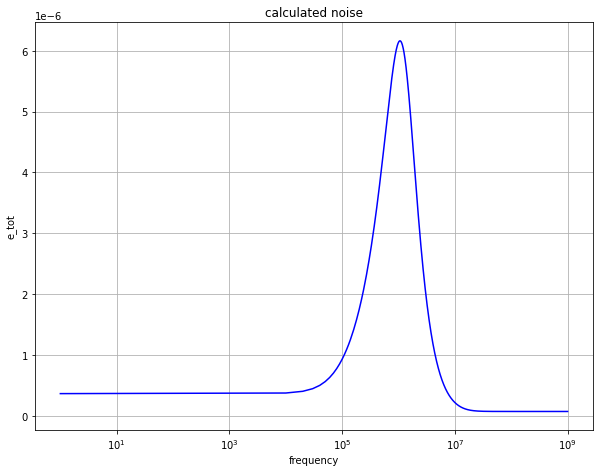

In [218]:
analyze(C_D, 1.6e-12, 130e3, e_namp_ada, i_namp_ada, f_T_ada, 1e-9, 100, 910, 6.2e3)

### 3. Schematic

Complete schematic showing the transimpedance stage, any additional gain stages, supply voltages, opamp models, resistor values, and all branch currents and DC node voltages. Indicate the power dissipated by each amplifier by annotating the current through the positive supply pin.

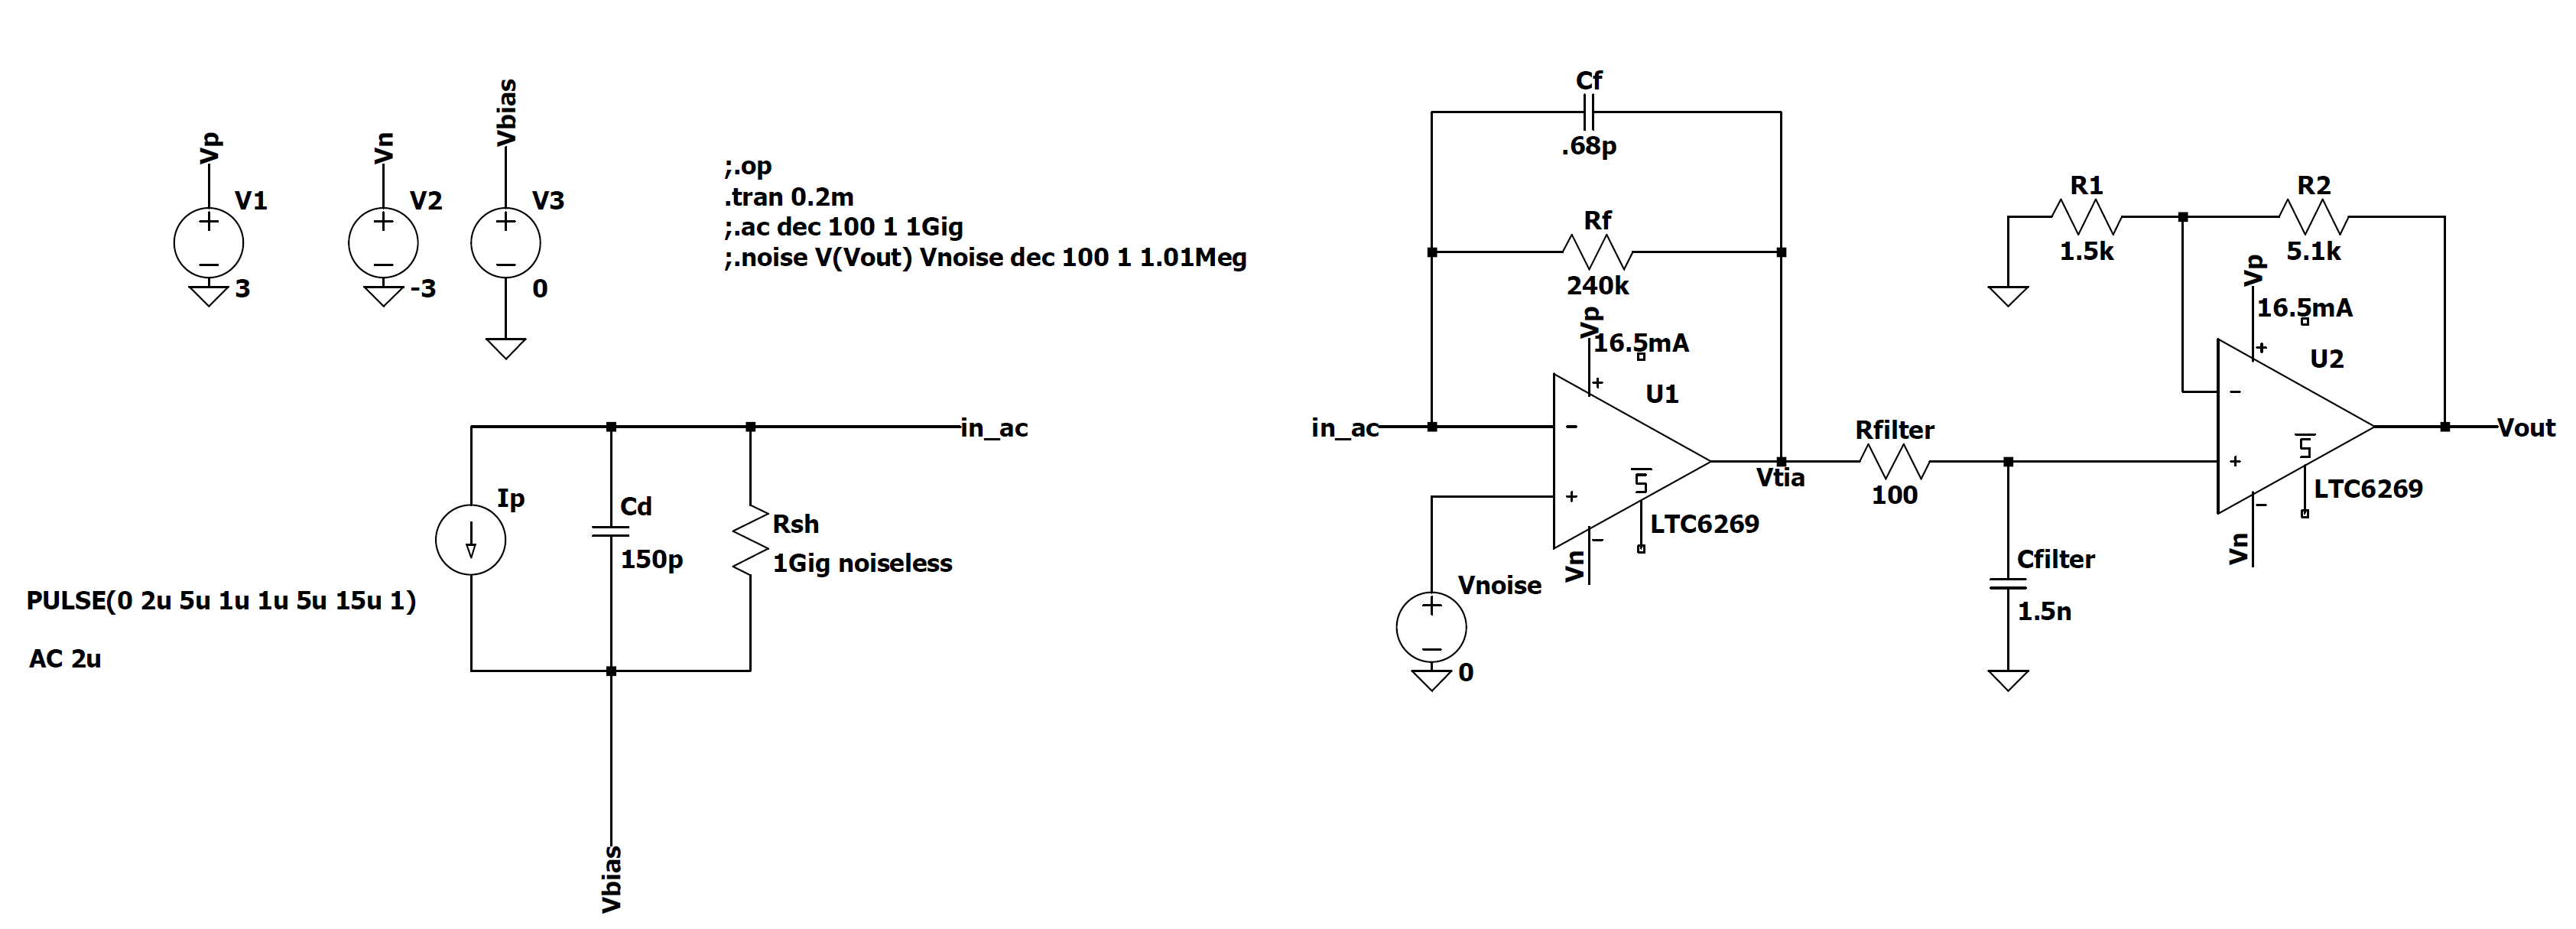

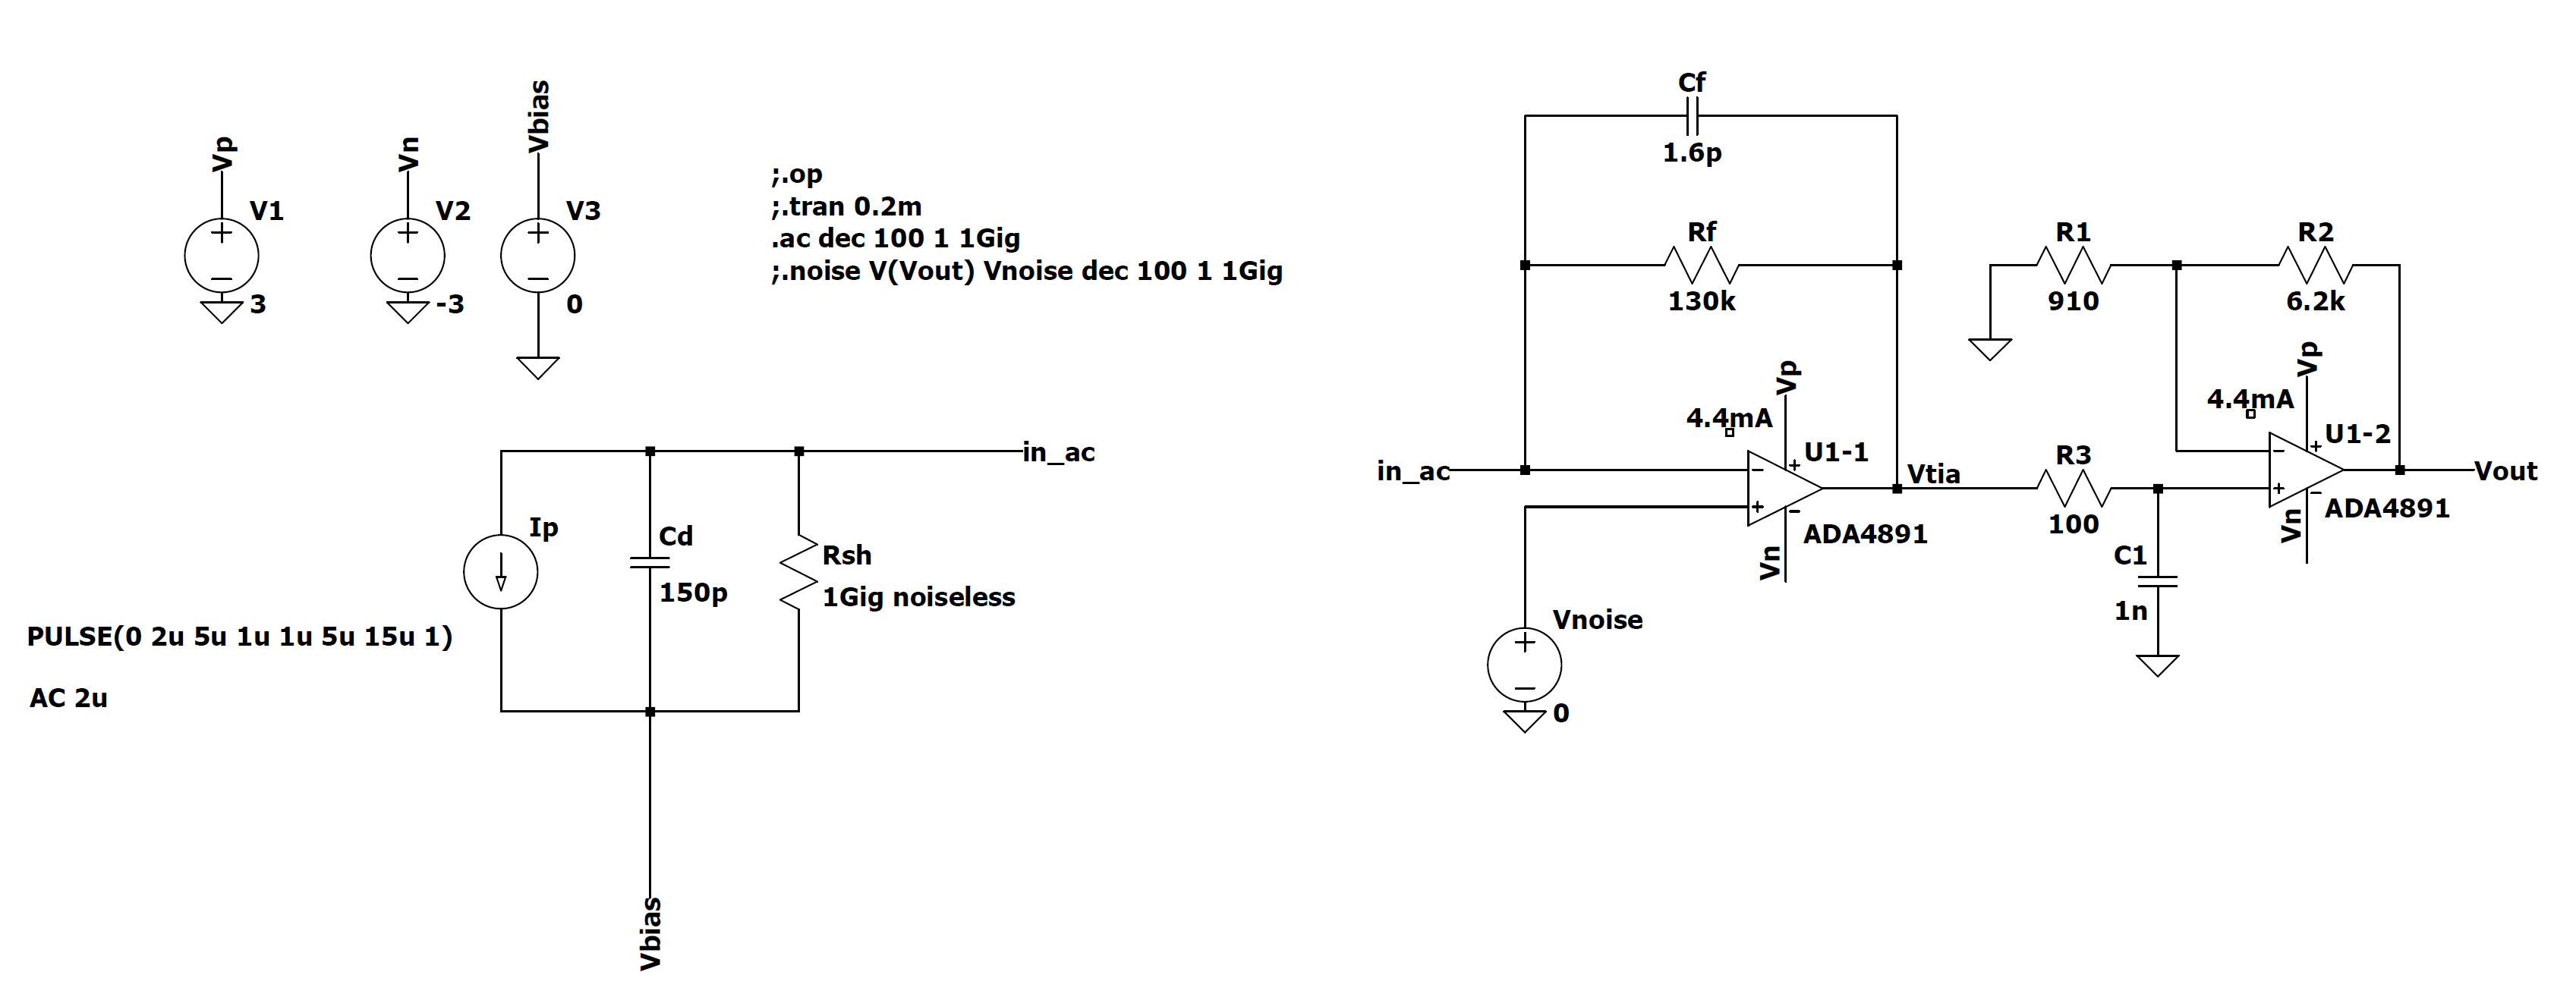

### Noise Contributions

A table summarizing noise contributions from all devices (opamps, transistors, and resistors) and the calculated input-referred noise density and  𝑟𝑚𝑠  noise of each.

### Bill of Materials

A table listing components used, quantity, active power (if applicable) and cost for each item assuming a purchase quantity of 1000, in addition to the total cost and power. Include a link to a Digikey (or equivalent) listing for each component.

## Verification

### Simulated Noise

Noise was simulated showing the input-referred noise noise from 1Hz to 1GHz and total 𝑟𝑚𝑠 noise. The noise was input-referred through dividing by the transconductance factor $1G\Omega$. The simulation for the LTC6269 structure closely matches the prediction for the noise peak as well as the rms noise. The predicted noise for the ADA6269 structure is higher than the simulation. This is because the ADA6269 datasheet does not list a value for $i_{namp}$ and a conservative guess was used in the prediction.

LTC6269 based structure RMS noise

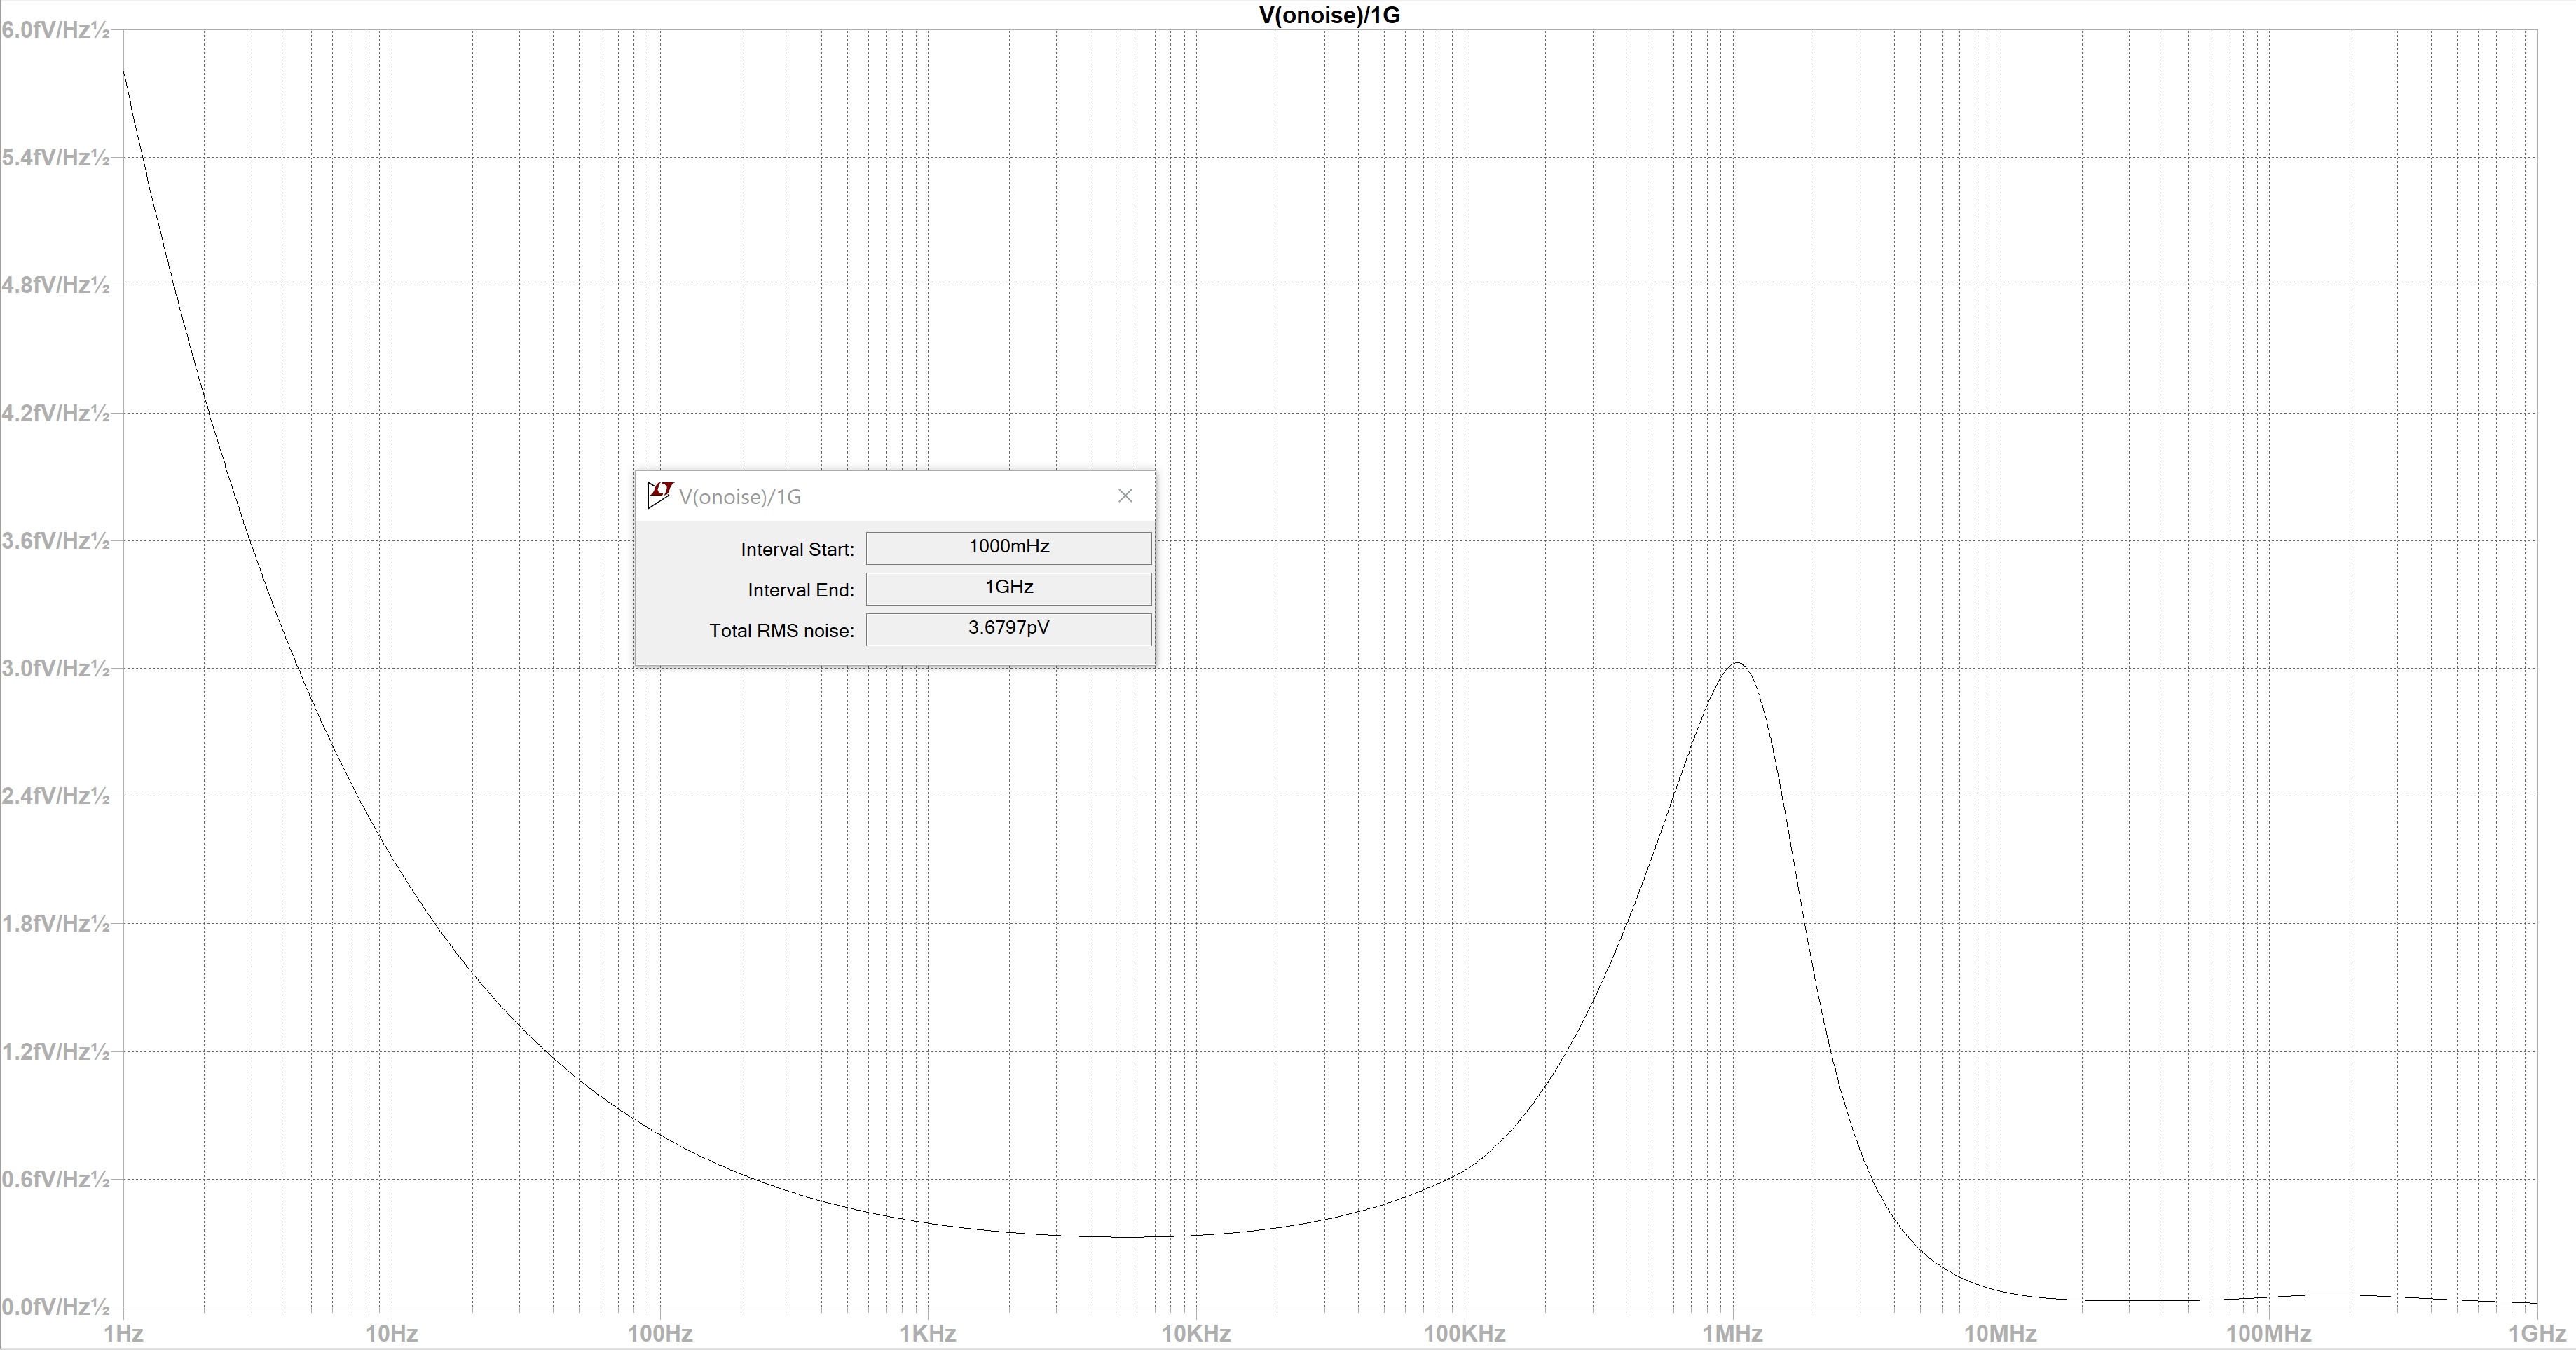

ADA4891 based structure simulated noise

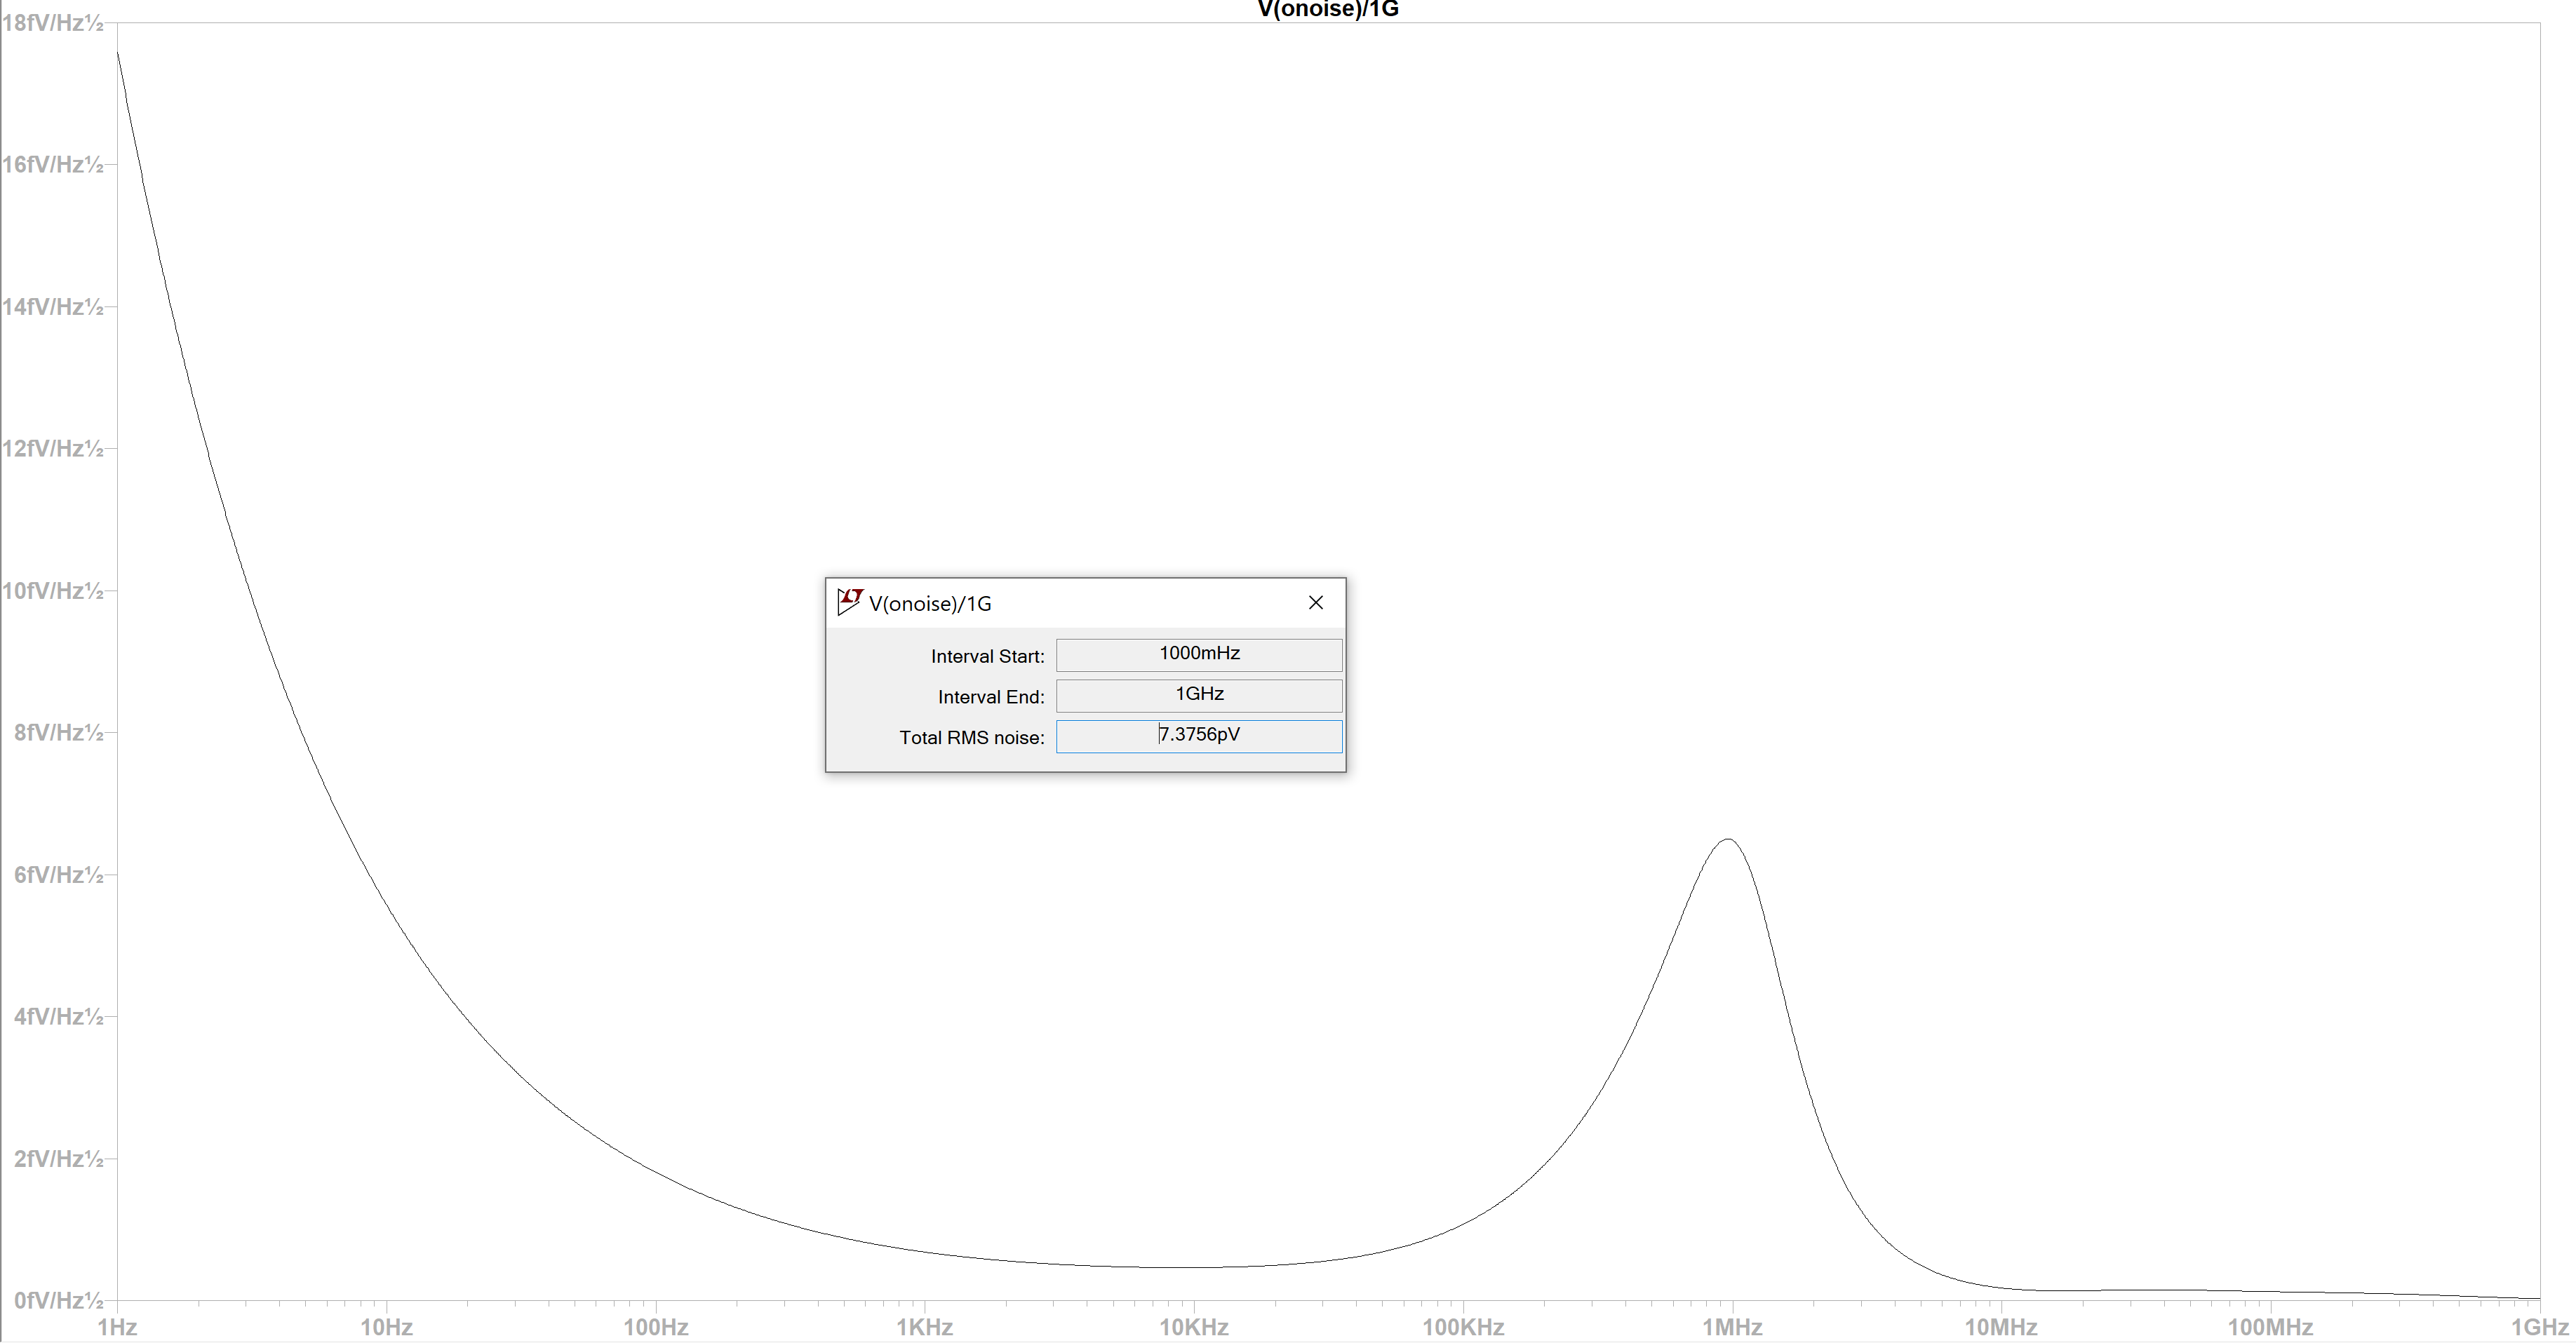

### Simulated Frequency Response

The frequency response prediction matches the simulation within the signal bandwidth. Beyond 10MHz both simulations show additional poles which are not present in the predictions due to assumptions of idealities.

'gain at 999.999999999991 Hz: 120.04316010454775 dB'

'gain at 999999.999999982 Hz: 116.92054053402506 dB'

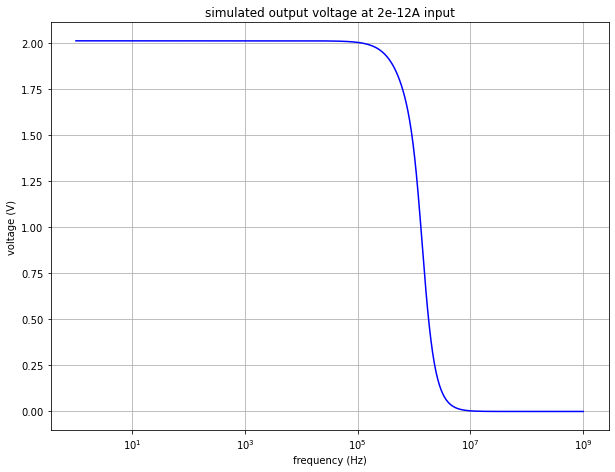

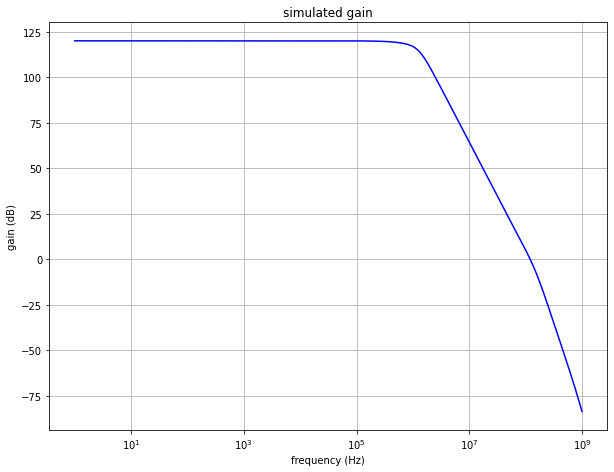

In [219]:
tia_ltc6269_ac_path = os.path.join(os.getcwd(), "TIA-LTC6269-AC.txt")

plot_ltspice_ac(tia_ltc6269_ac_path)

LTC6269 simulated gain and phase

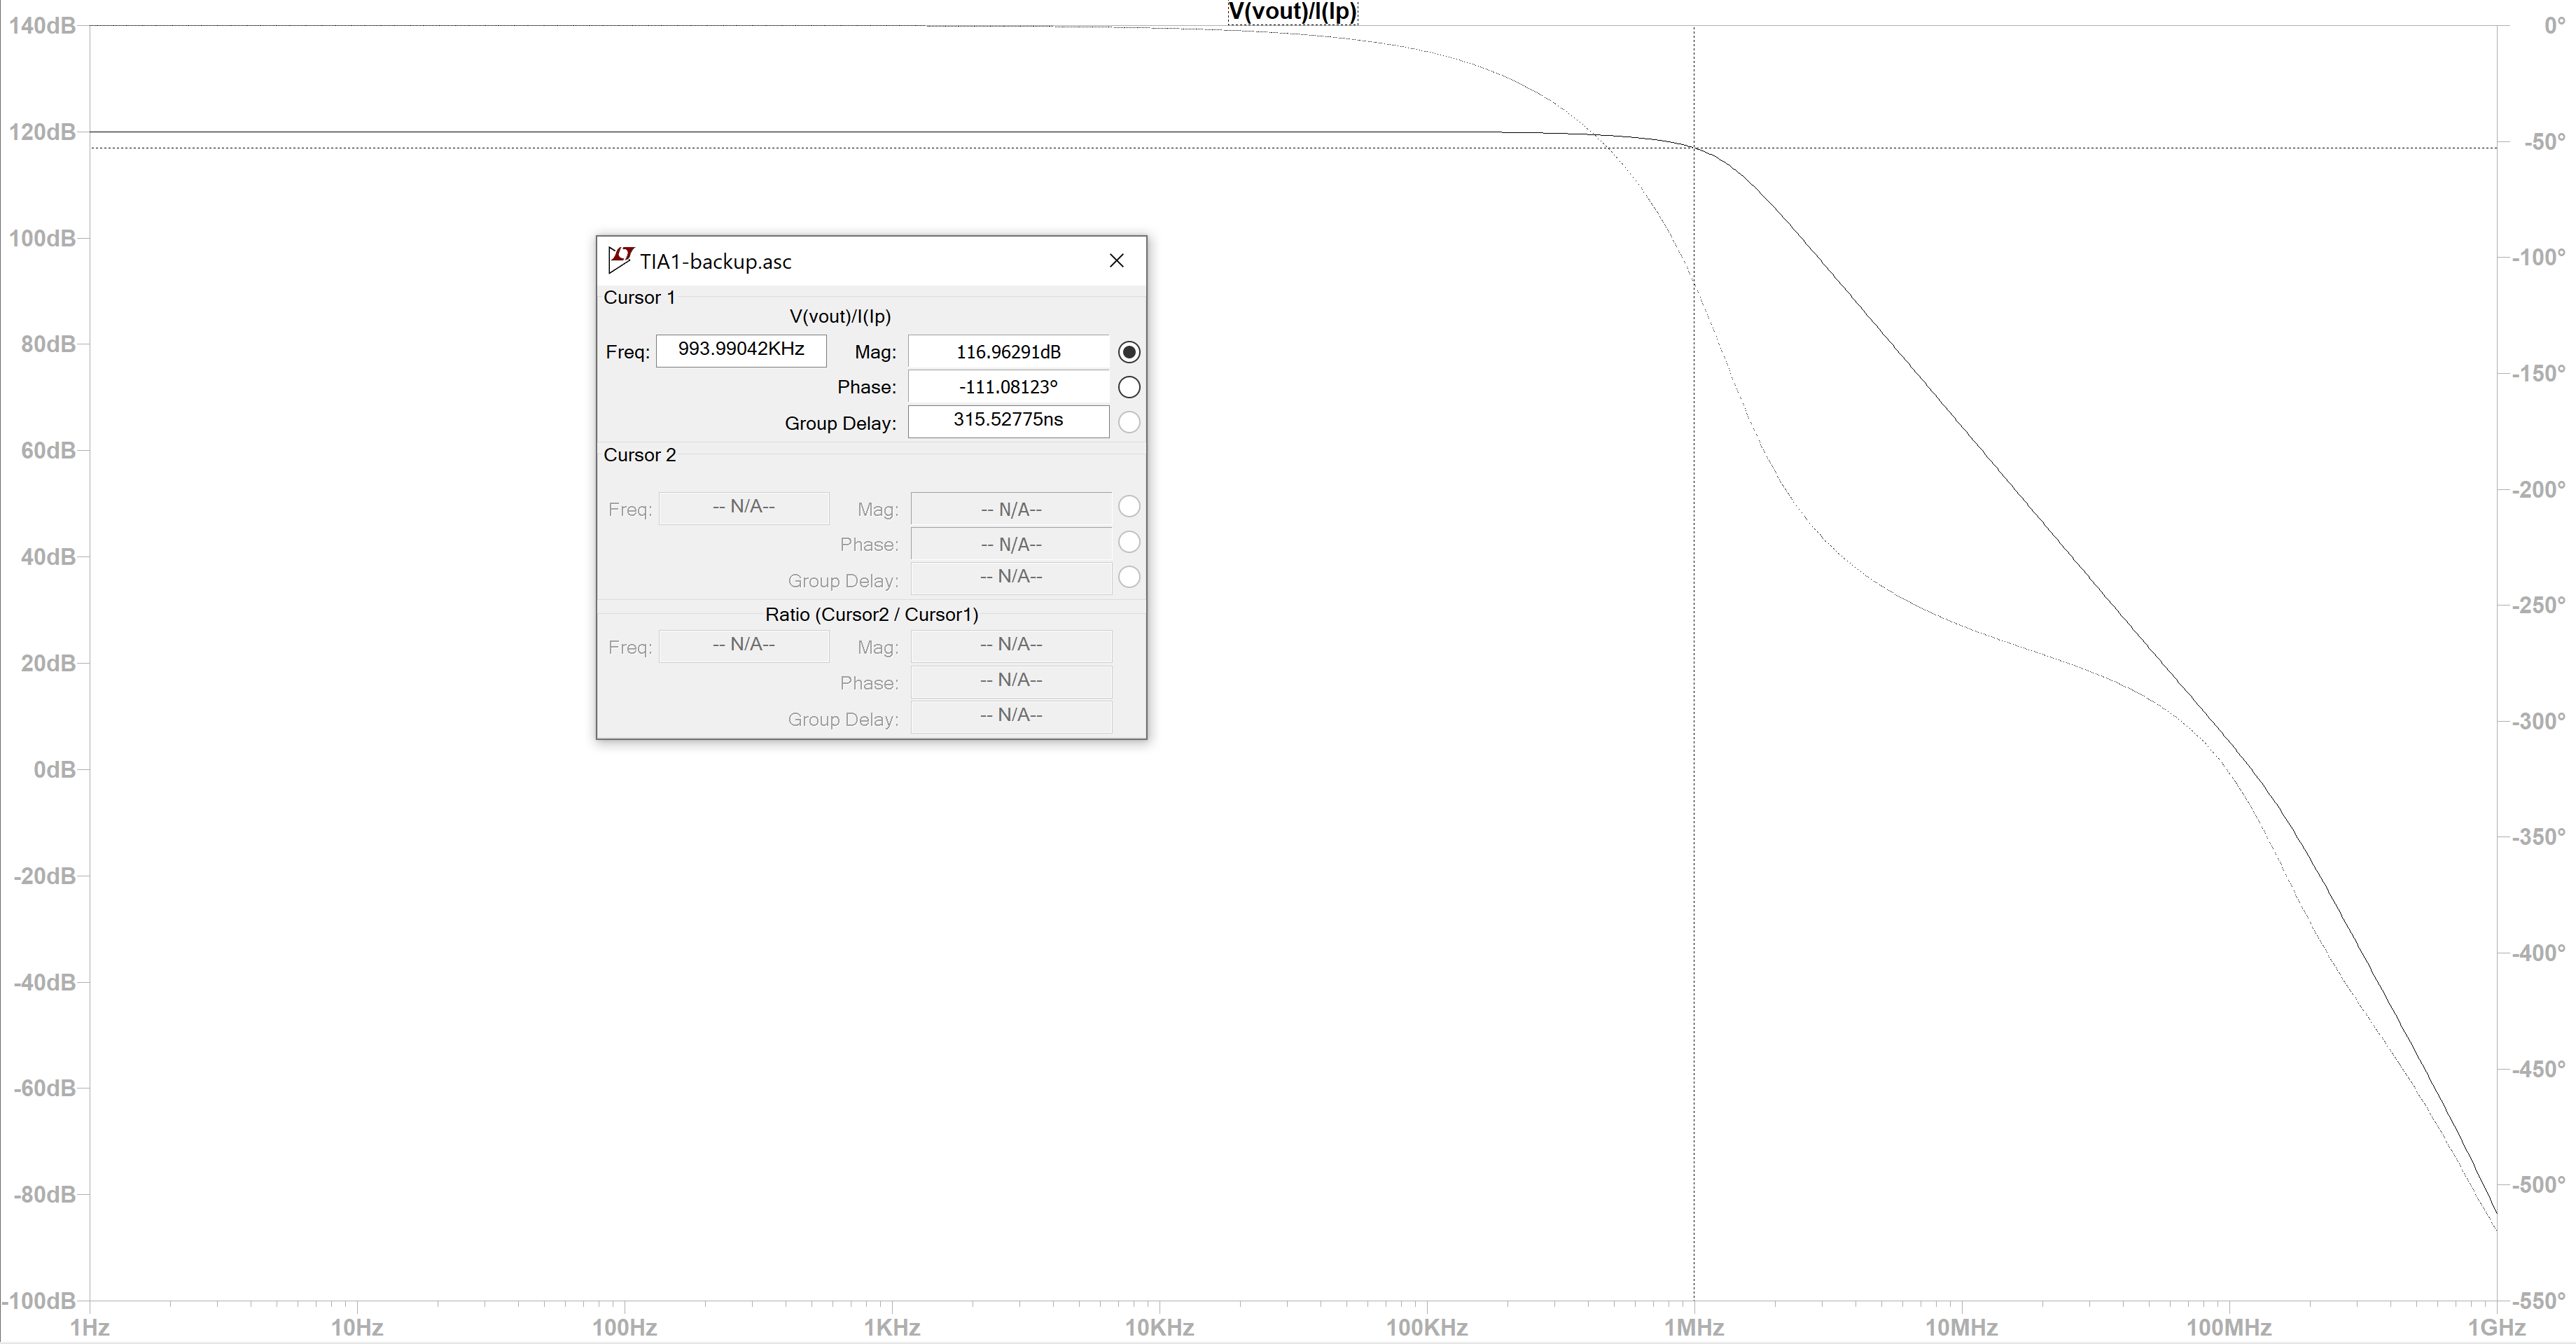

'gain at 999.999999999991 Hz: 120.13041638733681 dB'

'gain at 999999.999999982 Hz: 117.34174756499691 dB'

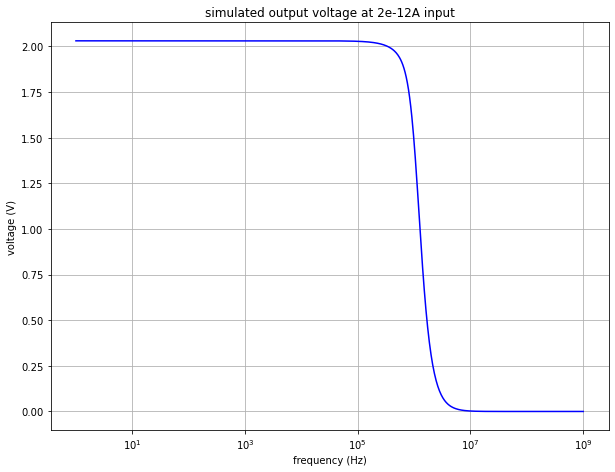

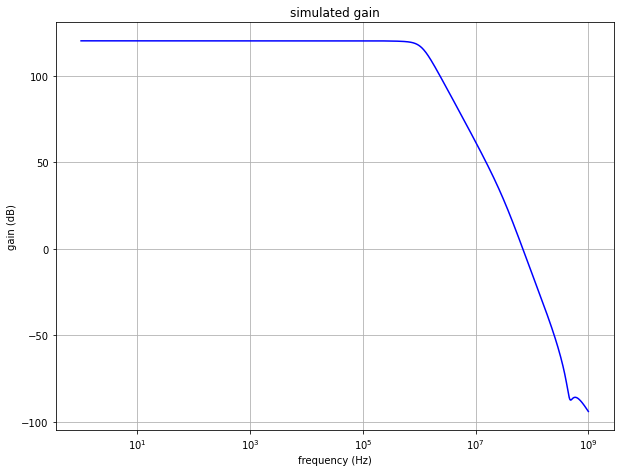

In [220]:
tia_ada4891_ac_path = os.path.join(os.getcwd(), "TIA-ADA4891-AC.txt")

plot_ltspice_ac(tia_ada4891_ac_path)

ADA4891 simulated gain and phase

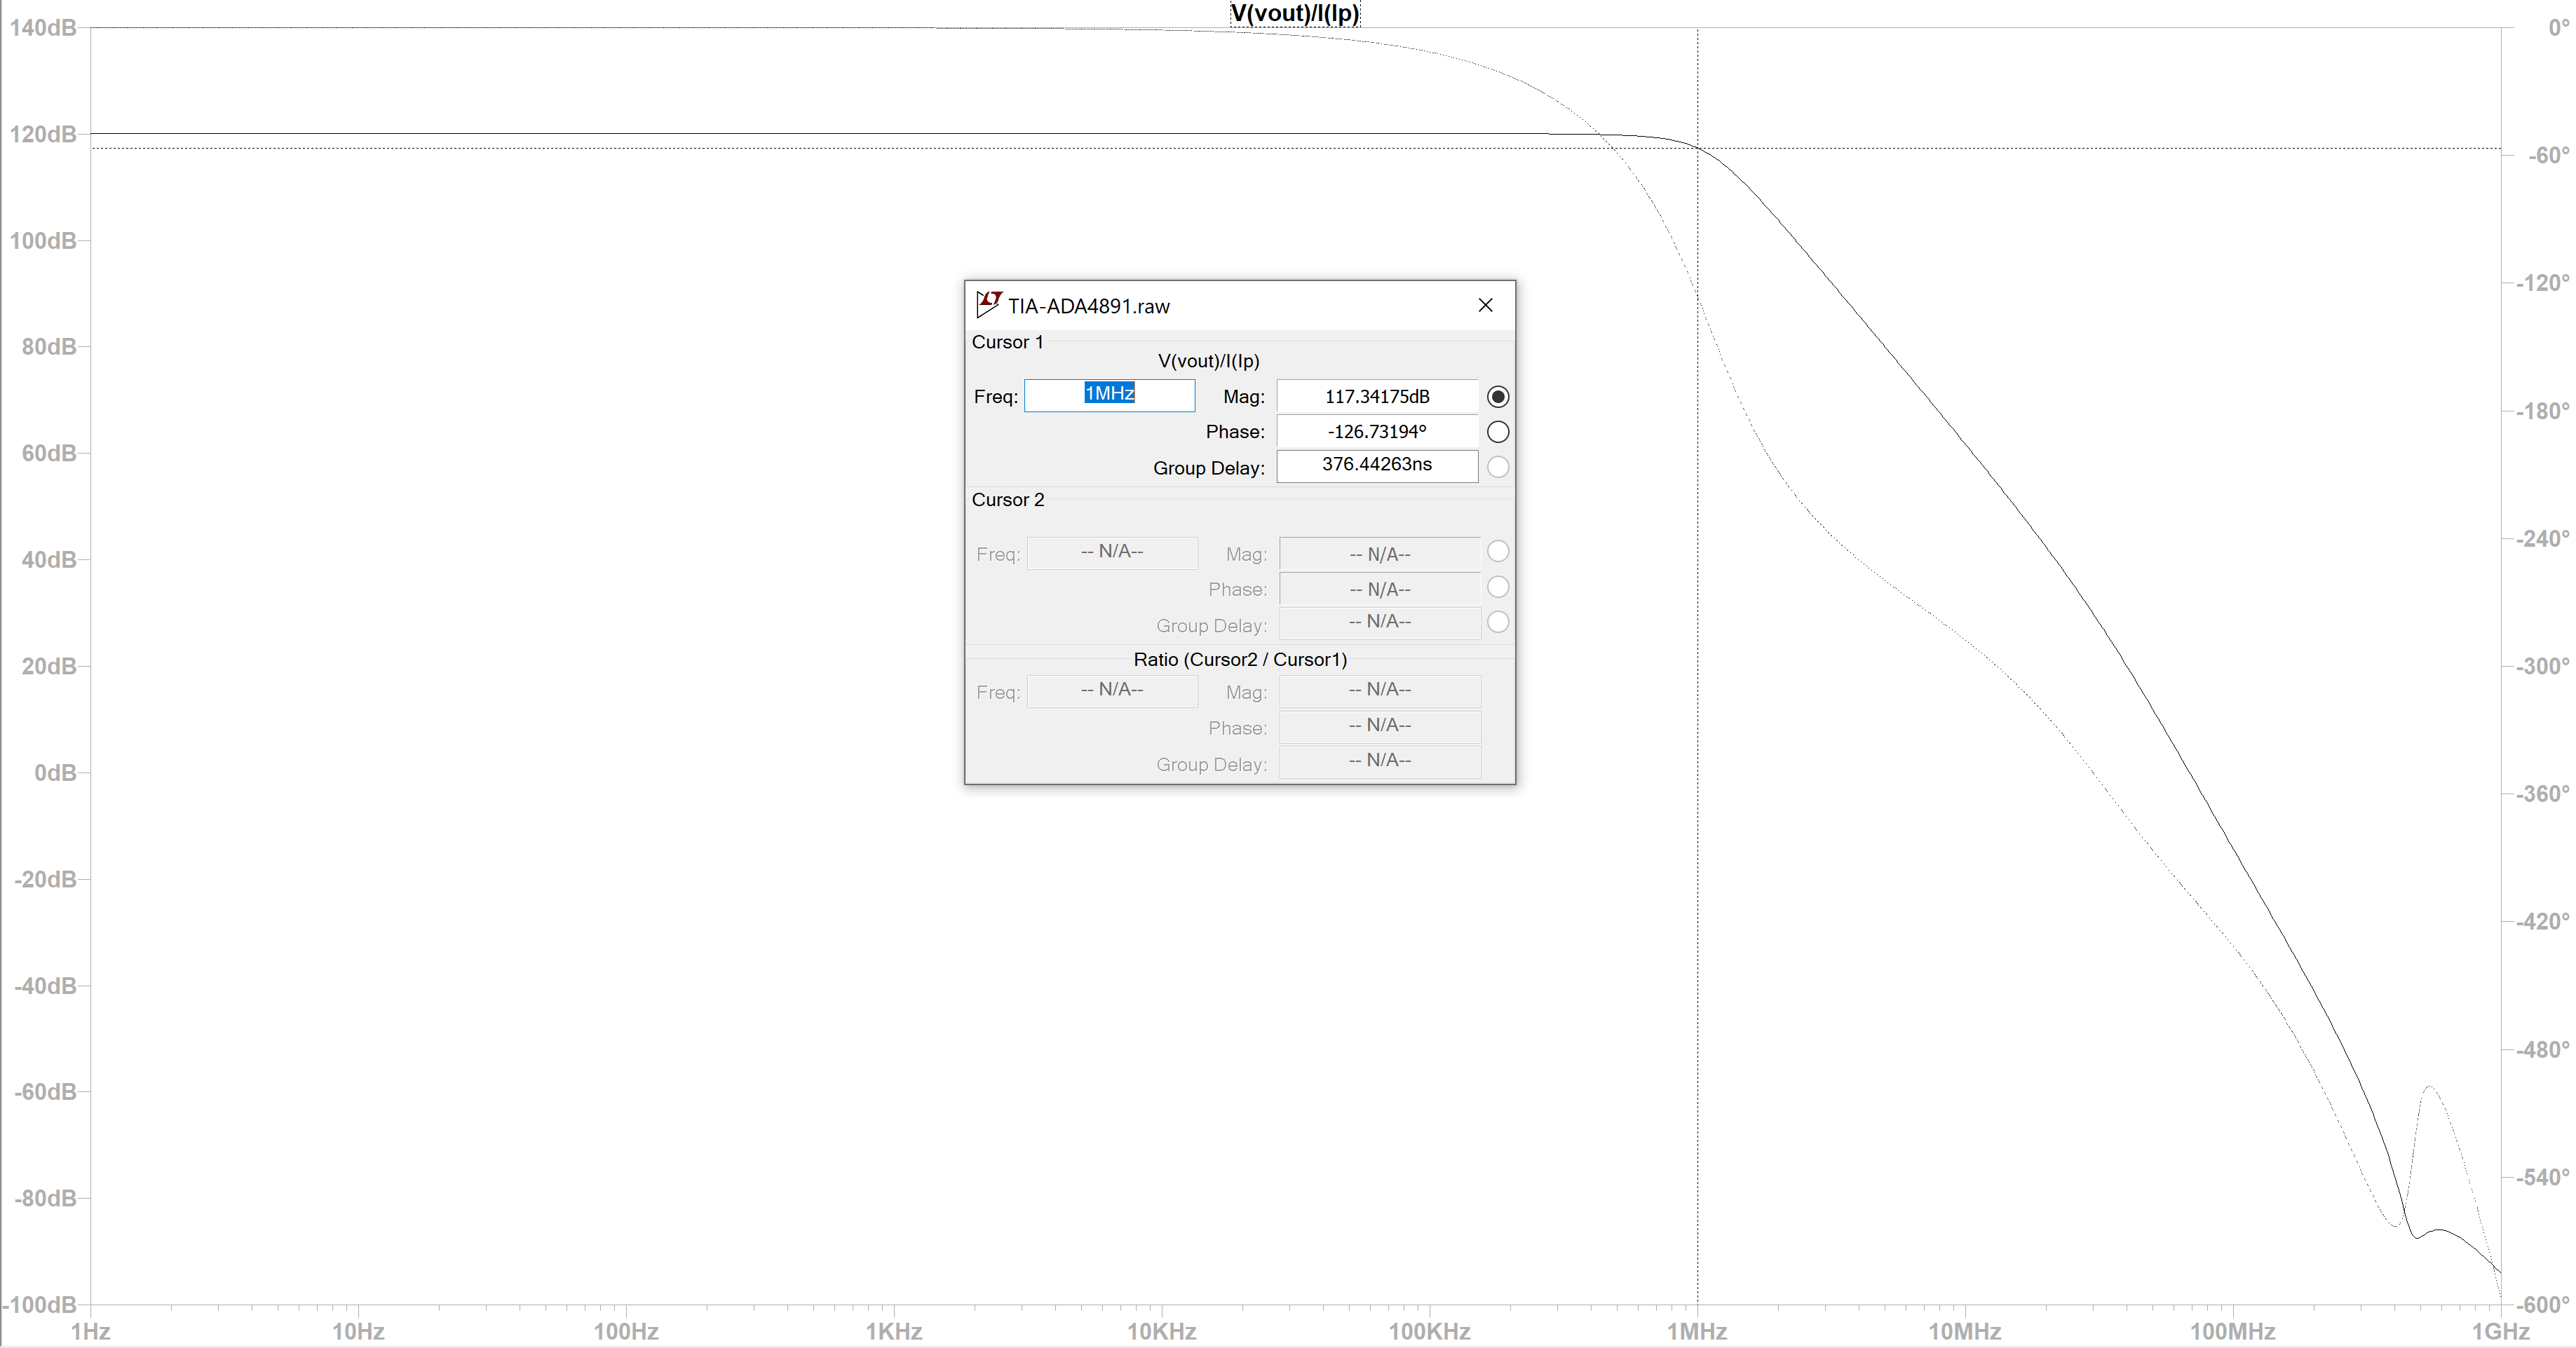

### Input Impedance

AC simulation result showing the input impedance as a function of frequency from 0.01Hz to 100MHz.

### Output Step Response

Output step response for an input current step of  0  to  2𝜇𝐴 was simulated.

The LTC6269 step response is fairly square. The ADA6269 structure however shows a $30mV$ ($0.01dB$) ripple at the signal edges. The reason for this ripple is that the ADA6269 has a smaller $f_T$ which means that a smaller value for $R_f$ needs to be used so that the structure is fast enough to cover the signal bandwidth. With a smaller $R_f$ value, $C_f$ needs to be chosen larger to keep oscillations under control. However, with larger $C_f$, the structure again becomes too slow to satisfy the required signal bandwidth. This $0.01dB$ ripple is the compromise necessary to implement the proposed structure cheaply.

LTC6269 step response

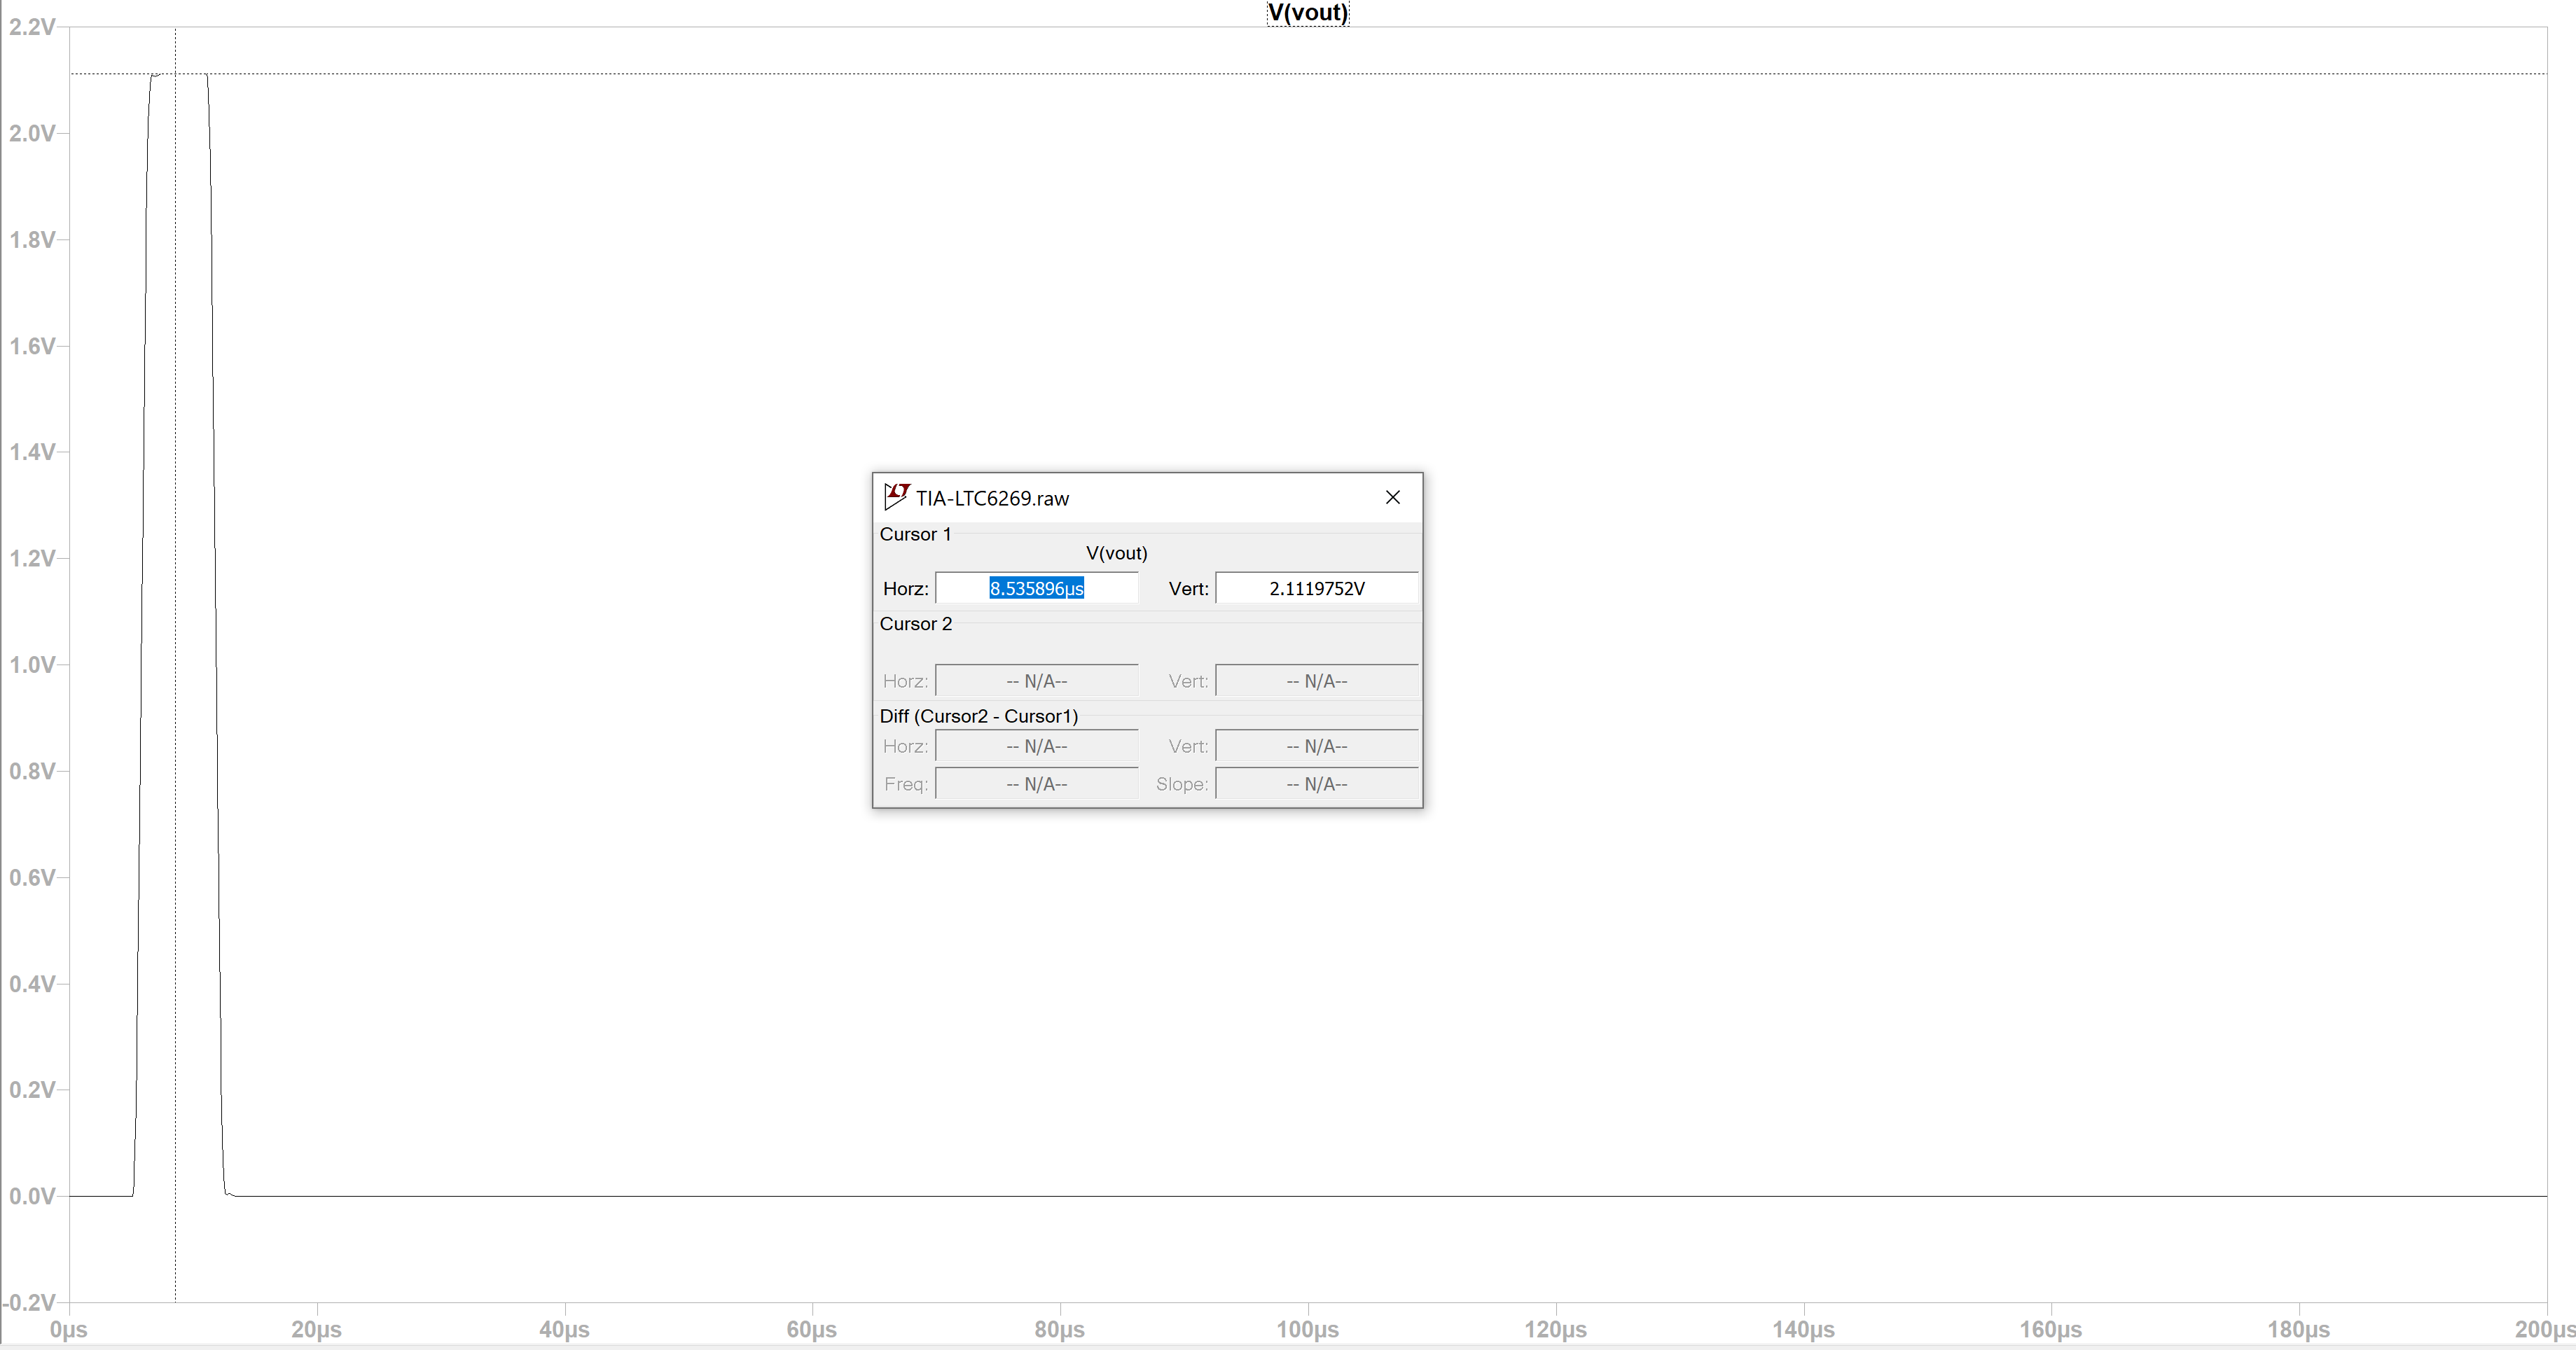

ADA4891 step response

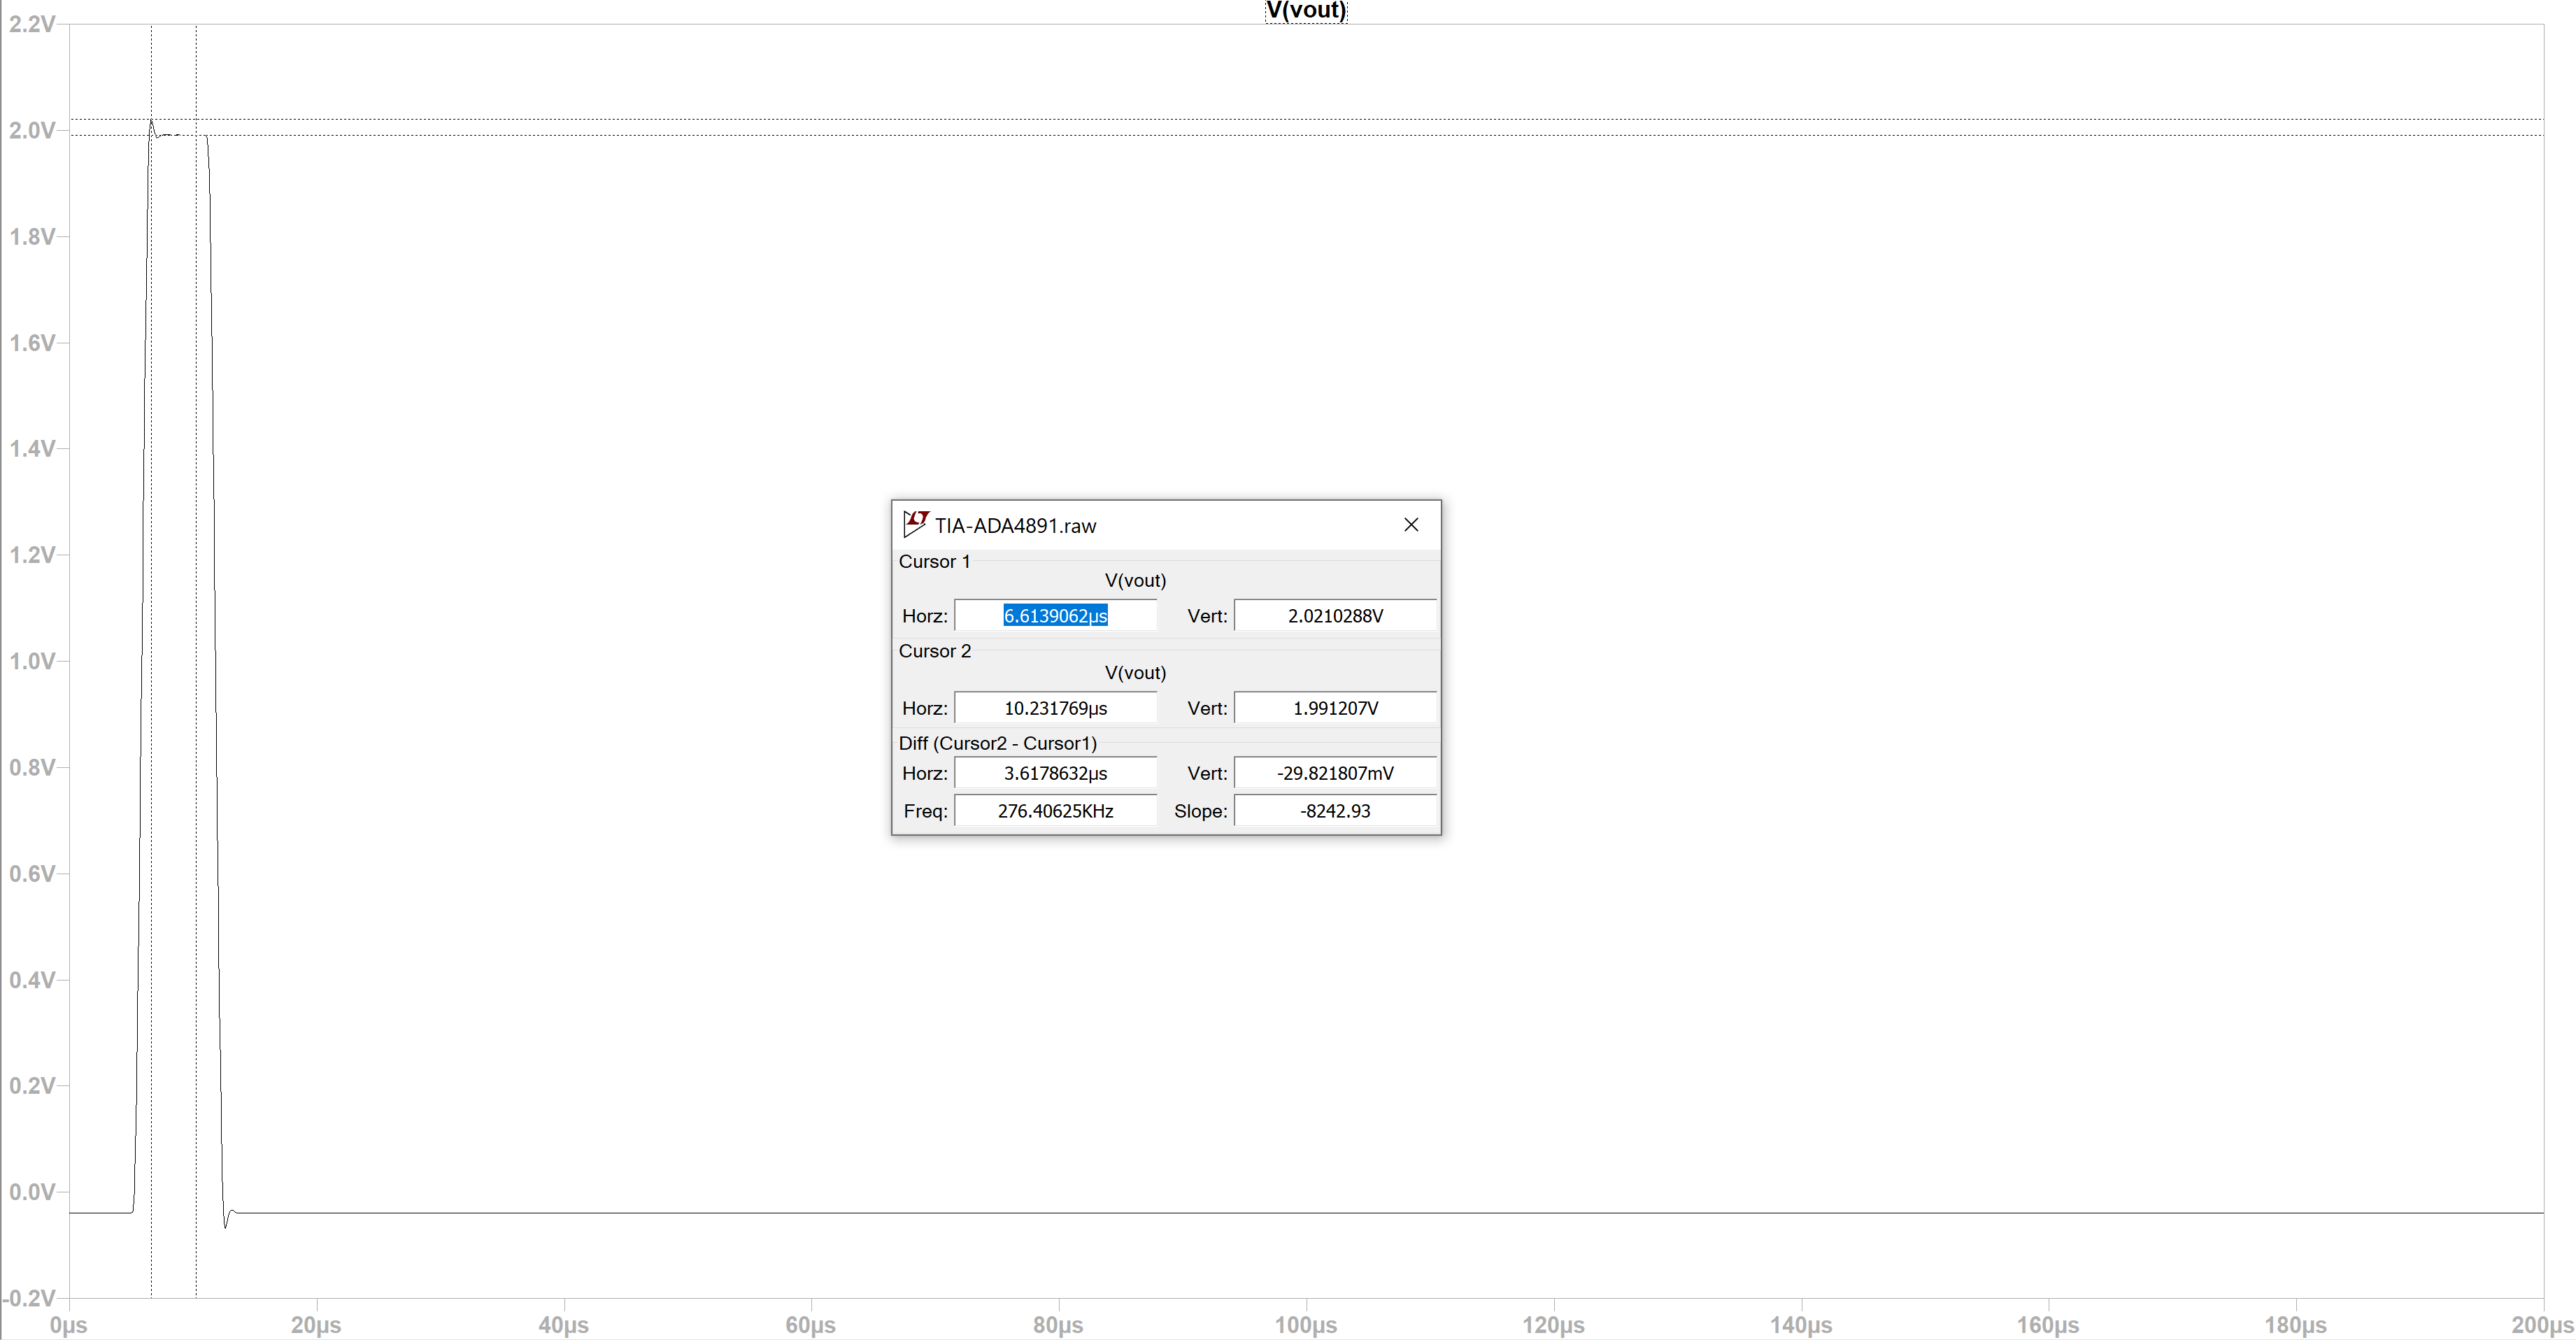

## Discussion

Include a discussion of major design tradeoffs, any insight you gained throughout the design process, and possible suggestions for improving the architecture.

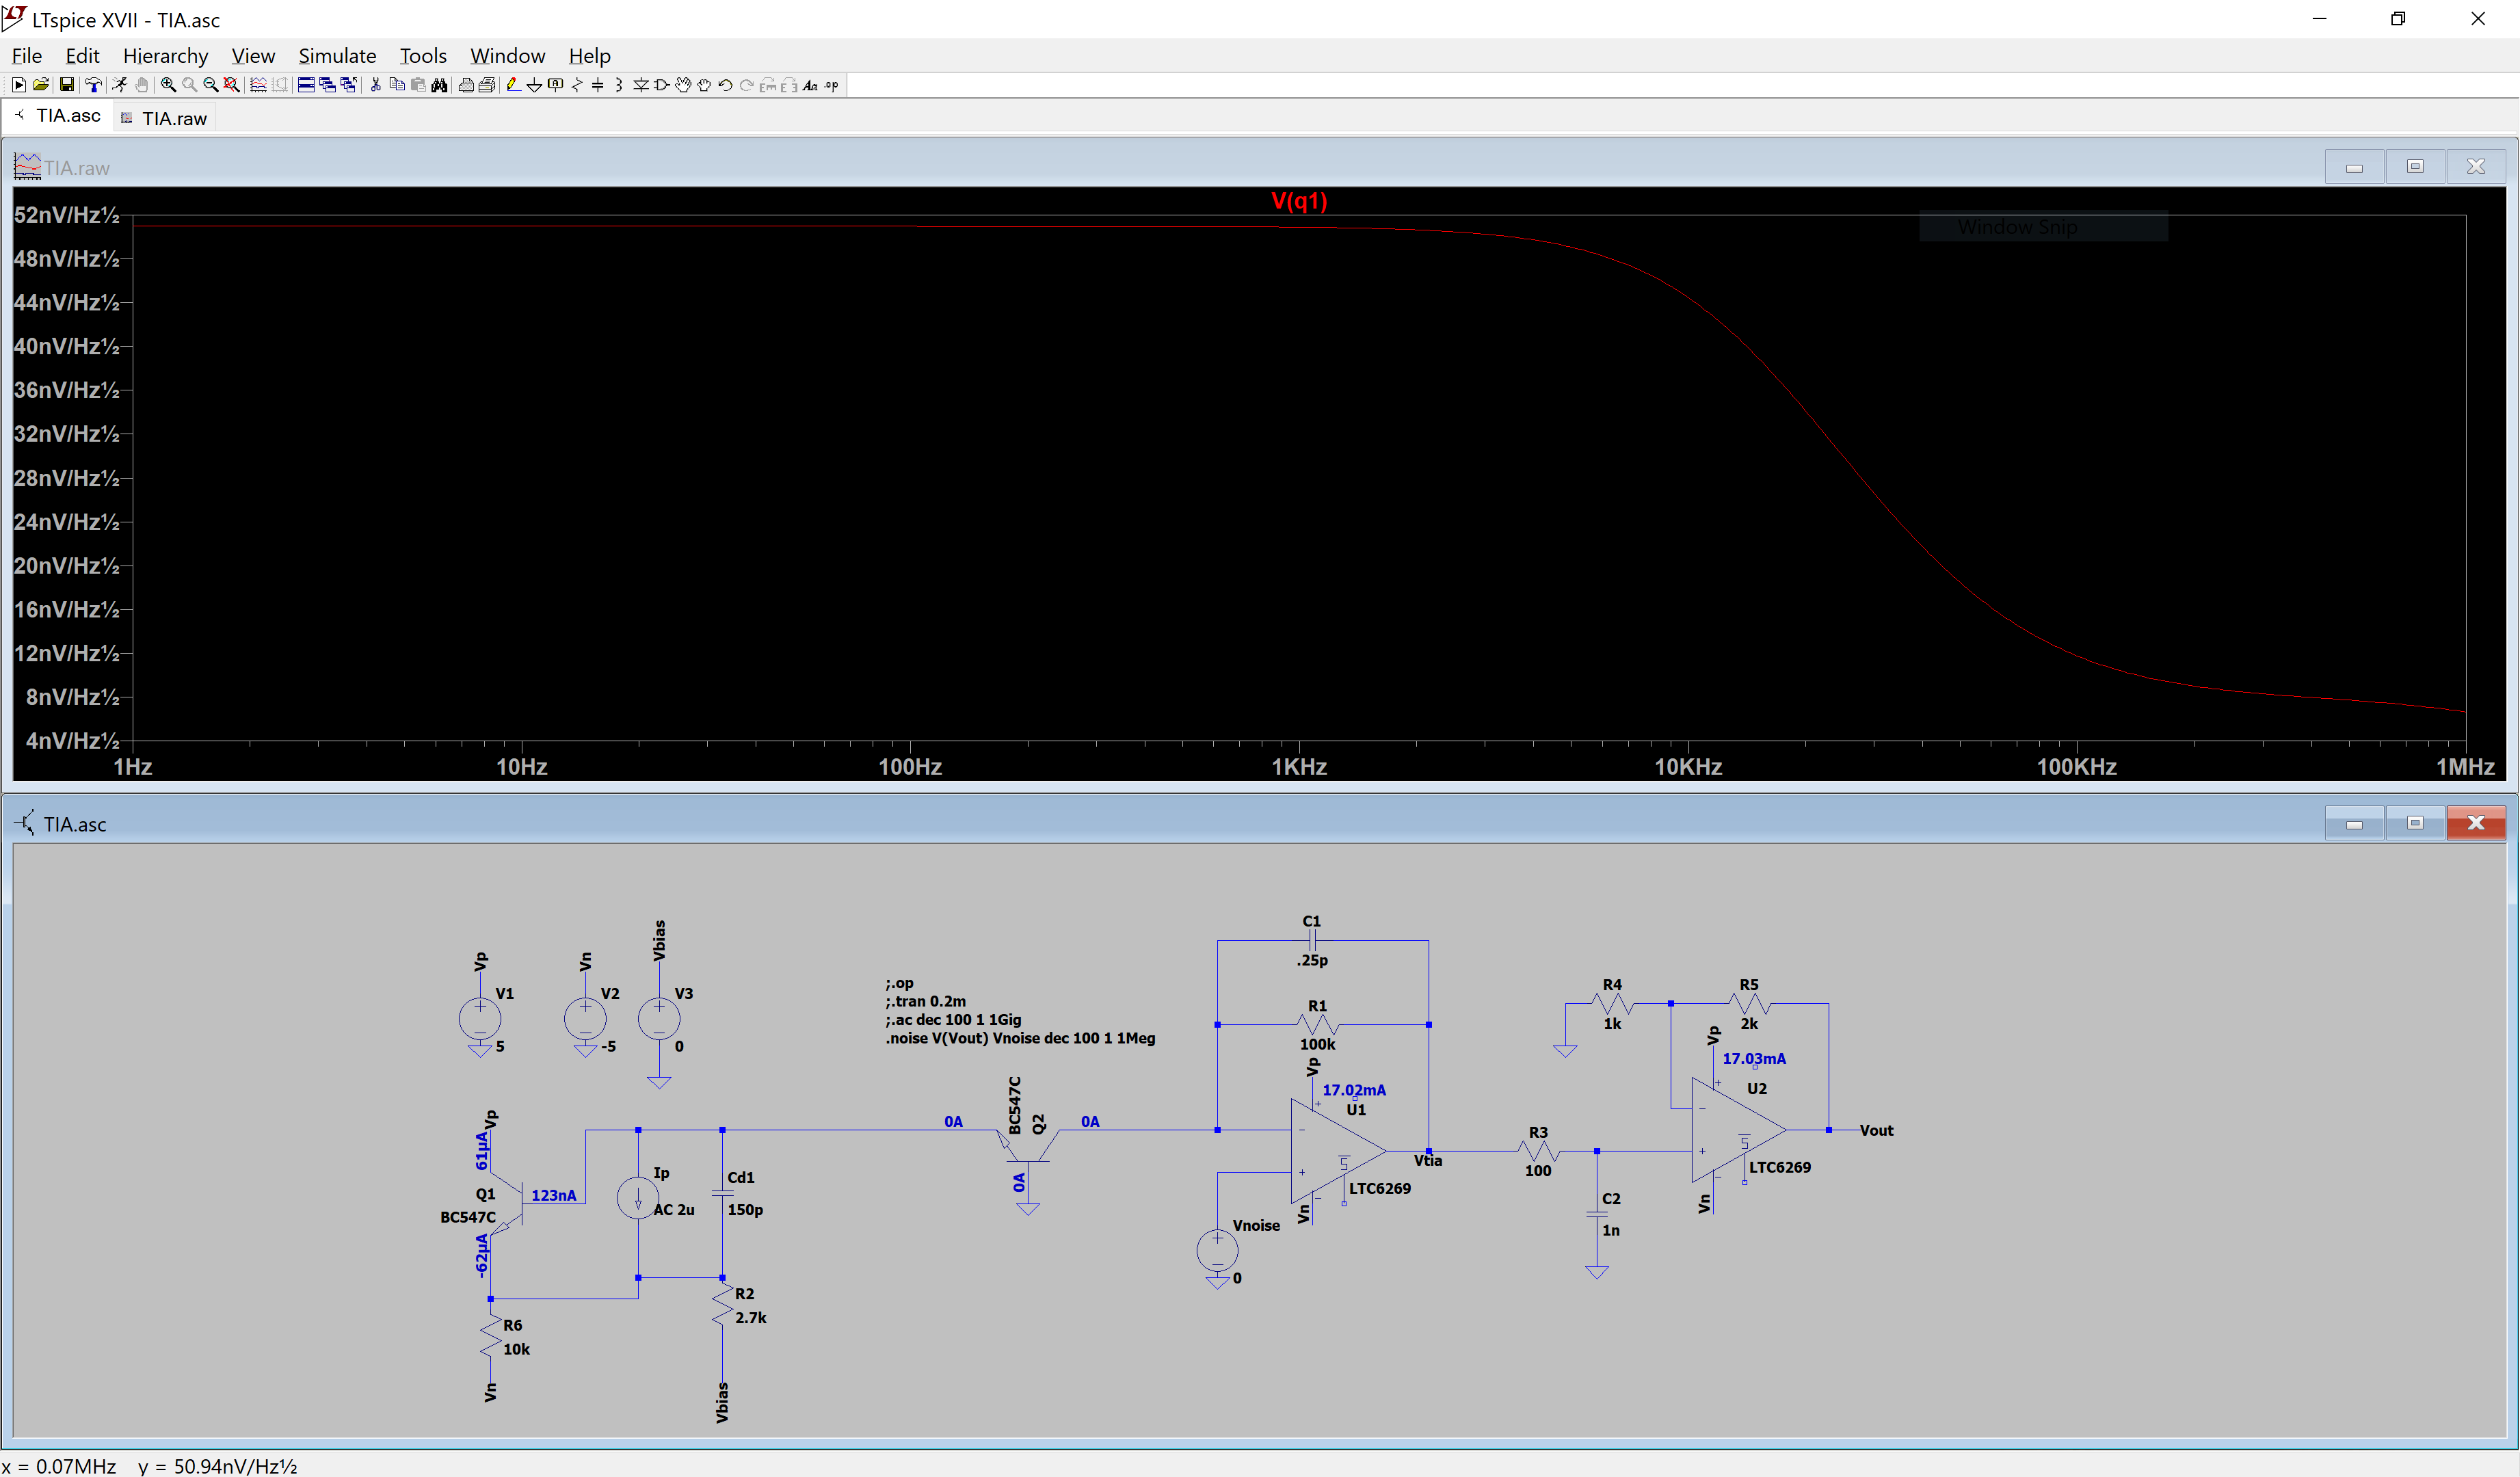